In [1]:
import cv2
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPool2D, Conv2DTranspose, UpSampling2D, Reshape, Layer, Lambda, LeakyReLU
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# results_AU movie is made with many frames
# Let's continue by skipping frames to have more diverse positions of the monster
# memory_size = 3200


In [3]:
output_path = 'video.avi'
fps = 10
image_counter=62561+1
memory_size = 3200
batch_size = 16
losses = []
frames = []
monster_ranges = []
image_shape = [480, 640,3]

In [4]:
# memory_size = 1600

In [5]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [6]:
480 * 640 * 3

921600

In [7]:
# out = vae_loss_test(images, autoencoder_model.predict(images))

In [8]:
# sess = tf.compat.v1.Session()

# # Evaluate the tensor `c`.
# print(sess.run(out[0]))
# print(sess.run(K.mean(out[1])))

In [9]:
# sess = tf.compat.v1.Session()
# scaled = frame[220:-200,:,1]-(frame[220:-200,:,0]+0.01)
# cutoff = tf.math.reduce_mean(scaled,axis=0)<-0.1
# cutoff = tf.dtypes.cast(cutoff, tf.int32)
# tf.nn.conv1d([cutoff], tf.ones((3,),dtype=tf.int32), stride=1, padding='SAME')
# sess.run()


In [32]:
from tensorflow.keras import metrics
# 
# @tf.function
# def vae_loss(y_true, y_pred):
#     # The size of the image is (480, 640, 3) so that is why we do the (480, 640, 3)
#     xent_loss = metrics.mse(K.flatten(y_true), K.flatten(y_pred))
#     kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     vae_loss = K.mean(xent_loss + kl_loss/9000)
#     return vae_loss

@tf.function
def my_vae_loss(y_true, y_pred,  z_log_var, z_mean):
            
    # The size of the image is (480, 640, 3) so that is why we do the (480, 640, 3)
#     zoomed_true, zoomed_output = y_true[:,220:-200], y_pred_zoomed[:,220:-200]
    xent_loss = metrics.mse(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss/90000)
    return vae_loss

# 62561 zoomed:0.00005 -> 0.0002
vae_optimizer = tf.keras.optimizers.Adam(0.0001)
zoomed_optimizer = tf.keras.optimizers.Adam(0.0002)

In [11]:
import scipy.ndimage.filters as fi

def gkern2(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    return fi.gaussian_filter(inp, nsig)

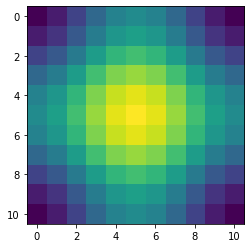

In [12]:
gauss_kernel_dim = 11
gauss_kernel = gkern2(gauss_kernel_dim,5)
plt.imshow(gauss_kernel)
# print(gauss_kernel)

gauss= Conv2D(3,(gauss_kernel_dim,gauss_kernel_dim), kernel_initializer='zeros', )
gauss.trainable = False
gauss.build(input_shape=[None]+[*image_shape])
org_weights = gauss.get_weights()
org_weights[0][:,:,0,0] = gauss_kernel
org_weights[0][:,:,1,1] = gauss_kernel
org_weights[0][:,:,2,2] = gauss_kernel
gauss.set_weights(org_weights)

In [13]:
# plt.imshow(gauss.get_weights()[0][:,:,0,0])

In [14]:
# encoding_dim = 24
encoding_dim = 16
encoder_input_layer = Input(image_shape)

encoder_layers = Conv2D(8, (3,3),padding="same")(encoder_input_layer)
encoder_layers = LeakyReLU(0.1)(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(16, (3,3), padding="same")(encoder_layers)
encoder_layers = LeakyReLU(0.1)(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(32, (3,3), padding="same")(encoder_layers)
encoder_layers = LeakyReLU(0.1)(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(32, (3,3), padding="same")(encoder_layers)
encoder_layers = LeakyReLU(0.1)(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Flatten()(encoder_layers)

encoder_layers = Dense(32)(encoder_layers)


# Create the Variational encoder part
z_mean = Dense(encoding_dim, name='z_mean')(encoder_layers)
z_log_var = Dense(encoding_dim, name='z_log_var')(encoder_layers)
encoder_layers = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])

# variational_encoder_kl_part = Model(input_layer, [z_mean, z_log_var, z])


# decoder_input_layer = Input([32])

decoder_layers = Dense(38400, input_shape=[encoding_dim])(encoder_layers)

decoder_layers = Reshape([30, 40, 32])(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(32, (3,3), padding="same")(decoder_layers)
decoder_layers = LeakyReLU(0.1)(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(32, (3,3), padding="same")(decoder_layers)
decoder_layers = LeakyReLU(0.1)(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(16, (3,3), padding="same")(decoder_layers)
decoder_layers = LeakyReLU(0.1)(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(8, (3,3), padding="same")(decoder_layers)
decoder_layers = LeakyReLU(0.1)(decoder_layers)

decoder_layers = Conv2D(3, (3,3), activation="sigmoid", padding="same")(decoder_layers)

class Focus(Layer):

  def __init__(self, x, y):
    super(Focus, self).__init__()
    self.x = x
    self.y = y

  def call(self, inputs):
    return inputs[self.x[0]:self.x[1],self.y[0]:self.y[1]]

focused_decoder_layers = Focus(x=(0,640),y=(220,280))(decoder_layers)
focused_decoder_layers = gauss(focused_decoder_layers)

# Models 
autoencoder_model = Model(encoder_input_layer, decoder_layers)
encoder_model = Model(encoder_input_layer, encoder_layers)
decoder_model = Sequential(autoencoder_model.layers[18:])



autoencoder_model = Model(encoder_input_layer, [decoder_layers, z_mean, z_log_var])
focused_autoencoder_model = Model(encoder_input_layer, [decoder_layers, focused_decoder_layers, z_mean, z_log_var])

In [15]:
# decoder_model = Sequential(autoencoder_model.layers[14:])
# decoder_model.inputs

In [16]:
# autoencoder_model.layers[13:]

In [17]:
# for key in (state.objects[0]):
    
# print( state.objects[0].name)

In [18]:
# Dead
# image_counter=42684+1
# Still alive
# image_counter=42062+1

# Compile model
# autoencoder_model.compile(optimizer="adam", loss=my_vae_loss)

In [19]:
# plt.imshow(autoencoder_model.predict(np.expand_dims(frame,0))[0])
# plt.figure()
# plt.imshow(frame)zoomed_16l_vae_leaky_temp_21323

In [20]:
# autoencoder_model.save_weights("./weights/AU_01_04_2020_0.h5")

In [25]:
# autoencoder_model.load_weights("./weights/AU_01_04_2020_0.h5")
focused_autoencoder_model.load_weights("./weights/zoomed_16l_vae_leaky_temp_{}.h5".format(image_counter-1))
# autoencoder_model.load_weights("./pretrained_weights/VAE_good_10_04_2020.h5")
# autoencoder_model.load_weights("./pretrained_weights/vae_good_17_04_2020.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


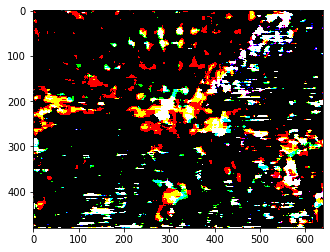

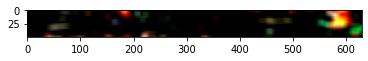

In [26]:
plt.imshow(focused_autoencoder_model.predict(np.random.randn(1,480, 640,3))[0][0])
plt.figure()
plt.imshow(focused_autoencoder_model.predict(np.random.randn(1,480, 640,3))[1][0])

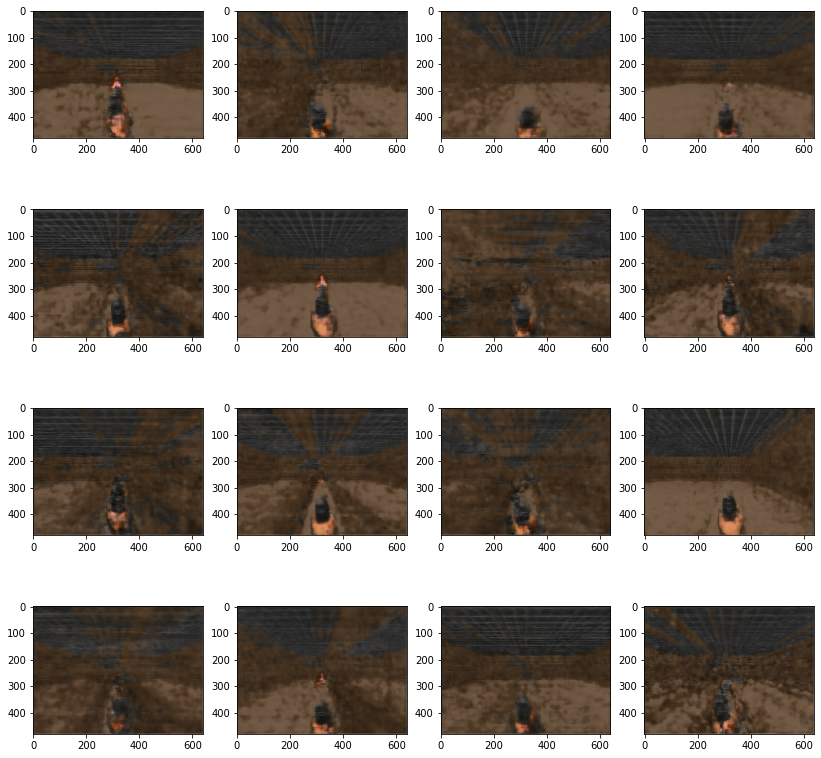

In [27]:
predictions = decoder_model.predict(np.random.randn(16,16))
plt.figure(figsize=(14,14))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i])
# plt.imshow(decoder_model.predict(np.random.randn(1,16))[1][0])

In [24]:
# plt.imshow(frames[0][220:-200,:,0])

In [25]:
# plt.imshow(frames[0][220:-200,:,1])

In [26]:
# scaled = frames[0][220:-200,:,1]-(frames[0][220:-200,:,0]+0.01)
# plt.imshow(scaled)

In [27]:
# mean_row = np.mean(scaled,axis=0)
# plt.plot(mean_row)

In [28]:
# cut_off = (mean_row < -0.1) * (mean_row > -0.16)
# plt.plot(cut_off)

In [29]:
# convolved_cutt_off = np.convolve(cut_off,[1,1,1,1,1], 'same')
# plt.plot(convolved_cutt_off)

In [30]:
# # nonzero = np.nonzero(convolved_cutt_off)
# mon_start , mon_end = (nonzero[0][0]-8, nonzero[0][-1]+8)

In [31]:
# plt.imshow(frames[0][220:-200,mon_start:mon_end])

In [32]:
# scaled = frames[0][220:-200,:,1]-(frames[0][220:-200,:,0]+0.01)
# mean_row = np.mean(scaled,axis=0)
# cut_off = mean_row < -0.1
# (nonzero[0][0], nonzero[0][-1])

In [33]:
# plt.imshow(frames[0][220:-200,:,2])

In [34]:
len(frames)

0

In [35]:
prediction = gauss(predictions)[0]

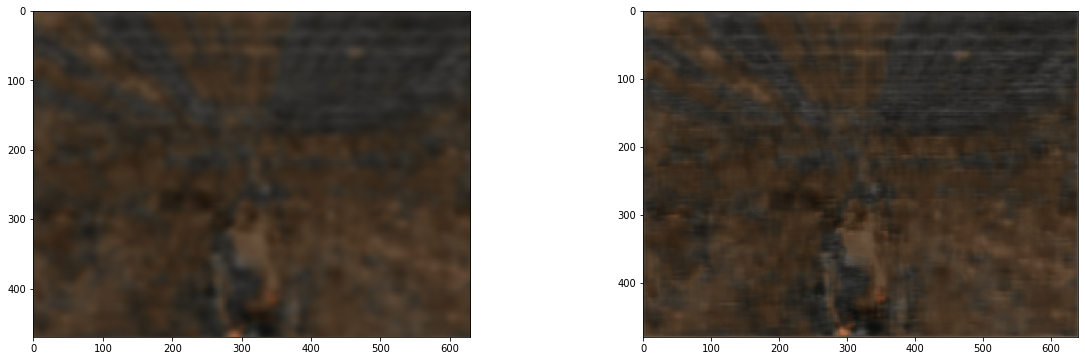

In [36]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.imshow(prediction)
plt.subplot(1,2,2)
plt.imshow(predictions[0])

In [37]:
len(frames)

0

In [38]:
# plt.imshow(gauss(np.array(frames[:1]))[0])

In [28]:
if np.max(gauss.get_weights()[0][:,:,0,0] - gauss_kernel) > 0.000001:
    print("Something is wrong with the filters!")

In [40]:

from __future__ import print_function
import vizdoom as vzd

from random import choice
from time import sleep

vizdoom_path = "../../../../Mech Punk/Anaconda3/envs/vizdoom/lib/vizdoom/scenarios/"

if __name__ == "__main__":
    # Create DoomGame instance. It will run the game and communicate with you.
    game = vzd.DoomGame()

    # Now it's time for configuration!
    # load_config could be used to load configuration instead of doing it here with code.
    # If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
    # game.load_config("../../scenarios/basic.cfg")

    # Sets path to additional resources wad file which is basically your scenario wad.
    # If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
    game.set_doom_scenario_path(vizdoom_path + "basic.wad")
    # Sets map to start (scenario .wad files can contain many maps).
    game.set_doom_map("map01")

    # Sets resolution. Default is 320X240
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

    # Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
    game.set_screen_format(vzd.ScreenFormat.RGB24)

    # Enables depth buffer.
    game.set_depth_buffer_enabled(True)

    # Enables labeling of in game objects labeling.
    game.set_labels_buffer_enabled(True)

    # Enables buffer with top down map of the current episode/level.
    game.set_automap_buffer_enabled(True)

    # Enables information about all objects present in the current episode/level.
    game.set_objects_info_enabled(True)

    # Enables information about all sectors (map layout).
    game.set_sectors_info_enabled(True)

    # Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)  # If hud is enabled
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)  # Bullet holes and blood on the walls
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)  # Smoke and blood
    game.set_render_messages(False)  # In-game messages
    game.set_render_corpses(False)
    game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

    # Adds buttons that will be allowed.
    game.add_available_button(vzd.Button.MOVE_LEFT)
    game.add_available_button(vzd.Button.MOVE_RIGHT)
    game.add_available_button(vzd.Button.ATTACK)

    # Adds game variables that will be included in state.
    game.add_available_game_variable(vzd.GameVariable.AMMO2)

    # Causes episodes to finish after 200 tics (actions)
    game.set_episode_timeout(200)

    # Makes episodes start after 10 tics (~after raising the weapon)
    game.set_episode_start_time(10)

    # Makes the window appear (turned on by default)
    game.set_window_visible(False)

    # Turns on the sound. (turned off by default)
    game.set_sound_enabled(False)

    # Sets the livin reward (for each move) to -1
    game.set_living_reward(-1)

    # Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
    game.set_mode(vzd.Mode.PLAYER)

    # Enables engine output to console.
    #game.set_console_enabled(True)

    # Initialize the game. Further configuration won't take any effect from now on.
    game.init()

    # Define some actions. Each list entry corresponds to declared buttons:
    # MOVE_LEFT, MOVE_RIGHT, ATTACK
    # game.get_available_buttons_size() can be used to check the number of available buttons.
    # 5 more combinations are naturally possible but only 3 are included for transparency when watching.
    actions = [[True, False, False], [False, True, False], [False, False, True]]

    # Run this many episodes
    episodes = 100000000

    # Sets time that will pause the engine after each action (in seconds)
    # Without this everything would go too fast for you to keep track of what's happening.
    sleep_time = 1.0 / vzd.DEFAULT_TICRATE  # = 0.028
    
    frame_counter = 0
    counter = 0

    for i in range(episodes):
        print("Episode #" + str(i + 1))
        if i % 1000 == 0:
#             focused_autoencoder_model.save_weights("./weights/zoomed_16l_vae_temp_{}.h5".format(image_counter))
            focused_autoencoder_model.save_weights("./weights/zoomed_16l_vae_leaky_temp_{}.h5".format(image_counter))

        # Starts a new episode. It is not needed right after init() but it doesn't cost much. At least the loop is nicer.
        game.new_episode()

        action_counter = 0
        
        while not game.is_episode_finished():
            
            action_counter-=1
            frame_counter+=1

            # Gets the state
            state = game.get_state()

            # Which consists of:
            n = state.number
            vars = state.game_variables
            screen_buf = state.screen_buffer
            depth_buf = state.depth_buffer
            labels_buf = state.labels_buffer
            automap_buf = state.automap_buffer
            labels = state.labels
            objects = state.objects
            sectors = state.sectors
            
#             frame = screen_buf/255
#             scaled = frame[220:-200,:,1]-(frame[220:-200,:,0]+0.01)
#             mean_row = np.mean(scaled,axis=0)
#             cut_off = np.array(mean_row < -0.1, dtype="int")
#             nonzero = np.nonzero(cut_off)
#             mon_start , mon_end = (nonzero[0][0]-8, nonzero[0][-1]+8)
#             plt.imshow(frame[220:-200,mon_start:mon_end,1])
#             plt.plot(mean_row)
#             plt.plot(-0.1*convolved_cutt_off)
#             plt.show()
#             time.sleep(0.05)
            
            
            if frame_counter % 11 == 0:
                frame = screen_buf/255
                frames.append(frame)
                
                
                scaled = frame[220:-200,:,1]-(frame[220:-200,:,0]+0.01)
                mean_row = np.mean(scaled,axis=0)
                cut_off = np.array(mean_row < -0.1, dtype="int")
                nonzero = np.nonzero(cut_off)
                if len(nonzero[0]) > 0:
                    mon_start , mon_end = (nonzero[0][0]-8, nonzero[0][-1]+8)
                else:
                    mon_start , mon_end = 100,140
                monster_ranges.append((int(mon_start) , int(mon_end)))
            
            
                if len(frames) > memory_size:
                    counter+=1
                    frames.pop(0)
                    monster_ranges.pop(0)

                if counter % batch_size == 0 and counter > batch_size-1:
#                     print('----a----')
                    batch_indices = np.random.choice(np.arange(len(frames)), batch_size, replace=False)

                    images = np.array([frames[index] for index in batch_indices], dtype="float32")
#                     selected_monster_ranges = np.array([monster_ranges[index] for index in batch_indices])  
#                     masks = np.zeros((batch_size, 60,640,3), dtype="float32")
#                     for monster_range_index, monster_range in enumerate(selected_monster_ranges):
#                         masks[monster_range_index,:,monster_range[0]:monster_range[1]]=1

                    zoomed_images = images[:,220:-200,:]
                    
                    with tf.GradientTape() as cvae_tape, tf.GradientTape() as zoomed_tape:
                        
                        [output, zoomed_output, z_mean, z_log_var] = focused_autoencoder_model(images, training=True)
#                         print(output.shape)
                        cvae_loss = my_vae_loss(images, output, z_mean, z_log_var)
                        zoomed_mse_loss = tf.keras.losses.mse(gauss(zoomed_images), zoomed_output)

                    gradients_of_cvae = cvae_tape.gradient(cvae_loss, focused_autoencoder_model.trainable_variables)
                    gradients_of_zoomed = zoomed_tape.gradient(zoomed_mse_loss, focused_autoencoder_model.trainable_variables)

                    vae_optimizer.apply_gradients(zip(gradients_of_cvae, focused_autoencoder_model.trainable_variables))
                    zoomed_optimizer.apply_gradients(zip(gradients_of_zoomed, focused_autoencoder_model.trainable_variables))
                    
                    
    #             if counter % 32 == 0 and counter > 31:
    #                 images = np.array(frames)
#                     loss = autoencoder_model.train_on_batch(images, selected_monster_ranges, images)
#                     losses.append(loss)
    #                 results.append(autoencoder_model.predict(np.expand_dims(frame, 0))[0])
    #                 print('a')
    #                 print(image_counter)
                    if image_counter % 10 == 0:
                        result = autoencoder_model.predict(np.expand_dims(frame, 0))[0][0]
                        RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
    #                     cv2.imwrite('../../../../Mech Punk/Documents/zoomed_16l_results/{}.png'.format(image_counter),RGB_img)
                        cv2.imwrite('../../../../Mech Punk/Documents/zoomed_16l_leaky_results/{}.png'.format(image_counter),RGB_img)
                    image_counter+=1

            if action_counter < 0:
                action = choice(actions)
                action_counter = np.random.randint(0,12)
            r = game.make_action(action)
            
    # It will be done automatically anyway but sometimes you need to do it in the middle of the program...
    game.close()

Episode #1
Episode #2
Episode #3
Episode #4
Episode #5
Episode #6
Episode #7
Episode #8
Episode #9
Episode #10
Episode #11
Episode #12
Episode #13
Episode #14
Episode #15
Episode #16
Episode #17
Episode #18
Episode #19
Episode #20
Episode #21
Episode #22
Episode #23
Episode #24
Episode #25
Episode #26
Episode #27
Episode #28
Episode #29
Episode #30
Episode #31
Episode #32
Episode #33
Episode #34
Episode #35
Episode #36
Episode #37
Episode #38
Episode #39
Episode #40
Episode #41
Episode #42
Episode #43
Episode #44
Episode #45
Episode #46
Episode #47
Episode #48
Episode #49
Episode #50
Episode #51
Episode #52
Episode #53
Episode #54
Episode #55
Episode #56
Episode #57
Episode #58
Episode #59
Episode #60
Episode #61
Episode #62
Episode #63
Episode #64
Episode #65
Episode #66
Episode #67
Episode #68
Episode #69
Episode #70
Episode #71
Episode #72
Episode #73
Episode #74
Episode #75
Episode #76
Episode #77
Episode #78
Episode #79
Episode #80
Episode #81
Episode #82
Episode #83
Episode #84
E

Episode #640
Episode #641
Episode #642
Episode #643
Episode #644
Episode #645
Episode #646
Episode #647
Episode #648
Episode #649
Episode #650
Episode #651
Episode #652
Episode #653
Episode #654
Episode #655
Episode #656
Episode #657
Episode #658
Episode #659
Episode #660
Episode #661
Episode #662
Episode #663
Episode #664
Episode #665
Episode #666
Episode #667
Episode #668
Episode #669
Episode #670
Episode #671
Episode #672
Episode #673
Episode #674
Episode #675
Episode #676
Episode #677
Episode #678
Episode #679
Episode #680
Episode #681
Episode #682
Episode #683
Episode #684
Episode #685
Episode #686
Episode #687
Episode #688
Episode #689
Episode #690
Episode #691
Episode #692
Episode #693
Episode #694
Episode #695
Episode #696
Episode #697
Episode #698
Episode #699
Episode #700
Episode #701
Episode #702
Episode #703
Episode #704
Episode #705
Episode #706
Episode #707
Episode #708
Episode #709
Episode #710
Episode #711
Episode #712
Episode #713
Episode #714
Episode #715
Episode #716

Episode #1251
Episode #1252
Episode #1253
Episode #1254
Episode #1255
Episode #1256
Episode #1257
Episode #1258
Episode #1259
Episode #1260
Episode #1261
Episode #1262
Episode #1263
Episode #1264
Episode #1265
Episode #1266
Episode #1267
Episode #1268
Episode #1269
Episode #1270
Episode #1271
Episode #1272
Episode #1273
Episode #1274
Episode #1275
Episode #1276
Episode #1277
Episode #1278
Episode #1279
Episode #1280
Episode #1281
Episode #1282
Episode #1283
Episode #1284
Episode #1285
Episode #1286
Episode #1287
Episode #1288
Episode #1289
Episode #1290
Episode #1291
Episode #1292
Episode #1293
Episode #1294
Episode #1295
Episode #1296
Episode #1297
Episode #1298
Episode #1299
Episode #1300
Episode #1301
Episode #1302
Episode #1303
Episode #1304
Episode #1305
Episode #1306
Episode #1307
Episode #1308
Episode #1309
Episode #1310
Episode #1311
Episode #1312
Episode #1313
Episode #1314
Episode #1315
Episode #1316
Episode #1317
Episode #1318
Episode #1319
Episode #1320
Episode #1321
Episod

Episode #1837
Episode #1838
Episode #1839
Episode #1840
Episode #1841
Episode #1842
Episode #1843
Episode #1844
Episode #1845
Episode #1846
Episode #1847
Episode #1848
Episode #1849
Episode #1850
Episode #1851
Episode #1852
Episode #1853
Episode #1854
Episode #1855
Episode #1856
Episode #1857
Episode #1858
Episode #1859
Episode #1860
Episode #1861
Episode #1862
Episode #1863
Episode #1864
Episode #1865
Episode #1866
Episode #1867
Episode #1868
Episode #1869
Episode #1870
Episode #1871
Episode #1872
Episode #1873
Episode #1874
Episode #1875
Episode #1876
Episode #1877
Episode #1878
Episode #1879
Episode #1880
Episode #1881
Episode #1882
Episode #1883
Episode #1884
Episode #1885
Episode #1886
Episode #1887
Episode #1888
Episode #1889
Episode #1890
Episode #1891
Episode #1892
Episode #1893
Episode #1894
Episode #1895
Episode #1896
Episode #1897
Episode #1898
Episode #1899
Episode #1900
Episode #1901
Episode #1902
Episode #1903
Episode #1904
Episode #1905
Episode #1906
Episode #1907
Episod

Episode #2423
Episode #2424
Episode #2425
Episode #2426
Episode #2427
Episode #2428
Episode #2429
Episode #2430
Episode #2431
Episode #2432
Episode #2433
Episode #2434
Episode #2435
Episode #2436
Episode #2437
Episode #2438
Episode #2439
Episode #2440
Episode #2441
Episode #2442
Episode #2443
Episode #2444
Episode #2445
Episode #2446
Episode #2447
Episode #2448
Episode #2449
Episode #2450
Episode #2451
Episode #2452
Episode #2453
Episode #2454
Episode #2455
Episode #2456
Episode #2457
Episode #2458
Episode #2459
Episode #2460
Episode #2461
Episode #2462
Episode #2463
Episode #2464
Episode #2465
Episode #2466
Episode #2467
Episode #2468
Episode #2469
Episode #2470
Episode #2471
Episode #2472
Episode #2473
Episode #2474
Episode #2475
Episode #2476
Episode #2477
Episode #2478
Episode #2479
Episode #2480
Episode #2481
Episode #2482
Episode #2483
Episode #2484
Episode #2485
Episode #2486
Episode #2487
Episode #2488
Episode #2489
Episode #2490
Episode #2491
Episode #2492
Episode #2493
Episod

Episode #3010
Episode #3011
Episode #3012
Episode #3013
Episode #3014
Episode #3015
Episode #3016
Episode #3017
Episode #3018
Episode #3019
Episode #3020
Episode #3021
Episode #3022
Episode #3023
Episode #3024
Episode #3025
Episode #3026
Episode #3027
Episode #3028
Episode #3029
Episode #3030
Episode #3031
Episode #3032
Episode #3033
Episode #3034
Episode #3035
Episode #3036
Episode #3037
Episode #3038
Episode #3039
Episode #3040
Episode #3041
Episode #3042
Episode #3043
Episode #3044
Episode #3045
Episode #3046
Episode #3047
Episode #3048
Episode #3049
Episode #3050
Episode #3051
Episode #3052
Episode #3053
Episode #3054
Episode #3055
Episode #3056
Episode #3057
Episode #3058
Episode #3059
Episode #3060
Episode #3061
Episode #3062
Episode #3063
Episode #3064
Episode #3065
Episode #3066
Episode #3067
Episode #3068
Episode #3069
Episode #3070
Episode #3071
Episode #3072
Episode #3073
Episode #3074
Episode #3075
Episode #3076
Episode #3077
Episode #3078
Episode #3079
Episode #3080
Episod

Episode #3597
Episode #3598
Episode #3599
Episode #3600
Episode #3601
Episode #3602
Episode #3603
Episode #3604
Episode #3605
Episode #3606
Episode #3607
Episode #3608
Episode #3609
Episode #3610
Episode #3611
Episode #3612
Episode #3613
Episode #3614
Episode #3615
Episode #3616
Episode #3617
Episode #3618
Episode #3619
Episode #3620
Episode #3621
Episode #3622
Episode #3623
Episode #3624
Episode #3625
Episode #3626
Episode #3627
Episode #3628
Episode #3629
Episode #3630
Episode #3631
Episode #3632
Episode #3633
Episode #3634
Episode #3635
Episode #3636
Episode #3637
Episode #3638
Episode #3639
Episode #3640
Episode #3641
Episode #3642
Episode #3643
Episode #3644
Episode #3645
Episode #3646
Episode #3647
Episode #3648
Episode #3649
Episode #3650
Episode #3651
Episode #3652
Episode #3653
Episode #3654
Episode #3655
Episode #3656
Episode #3657
Episode #3658
Episode #3659
Episode #3660
Episode #3661
Episode #3662
Episode #3663
Episode #3664
Episode #3665
Episode #3666
Episode #3667
Episod

Episode #4183
Episode #4184
Episode #4185
Episode #4186
Episode #4187
Episode #4188
Episode #4189
Episode #4190
Episode #4191
Episode #4192
Episode #4193
Episode #4194
Episode #4195
Episode #4196
Episode #4197
Episode #4198
Episode #4199
Episode #4200
Episode #4201
Episode #4202
Episode #4203
Episode #4204
Episode #4205
Episode #4206
Episode #4207
Episode #4208
Episode #4209
Episode #4210
Episode #4211
Episode #4212
Episode #4213
Episode #4214
Episode #4215
Episode #4216
Episode #4217
Episode #4218
Episode #4219
Episode #4220
Episode #4221
Episode #4222
Episode #4223
Episode #4224
Episode #4225
Episode #4226
Episode #4227
Episode #4228
Episode #4229
Episode #4230
Episode #4231
Episode #4232
Episode #4233
Episode #4234
Episode #4235
Episode #4236
Episode #4237
Episode #4238
Episode #4239
Episode #4240
Episode #4241
Episode #4242
Episode #4243
Episode #4244
Episode #4245
Episode #4246
Episode #4247
Episode #4248
Episode #4249
Episode #4250
Episode #4251
Episode #4252
Episode #4253
Episod

Episode #4769
Episode #4770
Episode #4771
Episode #4772
Episode #4773
Episode #4774
Episode #4775
Episode #4776
Episode #4777
Episode #4778
Episode #4779
Episode #4780
Episode #4781
Episode #4782
Episode #4783
Episode #4784
Episode #4785
Episode #4786
Episode #4787
Episode #4788
Episode #4789
Episode #4790
Episode #4791
Episode #4792
Episode #4793
Episode #4794
Episode #4795
Episode #4796
Episode #4797
Episode #4798
Episode #4799
Episode #4800
Episode #4801
Episode #4802
Episode #4803
Episode #4804
Episode #4805
Episode #4806
Episode #4807
Episode #4808
Episode #4809
Episode #4810
Episode #4811
Episode #4812
Episode #4813
Episode #4814
Episode #4815
Episode #4816
Episode #4817
Episode #4818
Episode #4819
Episode #4820
Episode #4821
Episode #4822
Episode #4823
Episode #4824
Episode #4825
Episode #4826
Episode #4827
Episode #4828
Episode #4829
Episode #4830
Episode #4831
Episode #4832
Episode #4833
Episode #4834
Episode #4835
Episode #4836
Episode #4837
Episode #4838
Episode #4839
Episod

Episode #5355
Episode #5356
Episode #5357
Episode #5358
Episode #5359
Episode #5360
Episode #5361
Episode #5362
Episode #5363
Episode #5364
Episode #5365
Episode #5366
Episode #5367
Episode #5368
Episode #5369
Episode #5370
Episode #5371
Episode #5372
Episode #5373
Episode #5374
Episode #5375
Episode #5376
Episode #5377
Episode #5378
Episode #5379
Episode #5380
Episode #5381
Episode #5382
Episode #5383
Episode #5384
Episode #5385
Episode #5386
Episode #5387
Episode #5388
Episode #5389
Episode #5390
Episode #5391
Episode #5392
Episode #5393
Episode #5394
Episode #5395
Episode #5396
Episode #5397
Episode #5398
Episode #5399
Episode #5400
Episode #5401
Episode #5402
Episode #5403
Episode #5404
Episode #5405
Episode #5406
Episode #5407
Episode #5408
Episode #5409
Episode #5410
Episode #5411
Episode #5412
Episode #5413
Episode #5414
Episode #5415
Episode #5416
Episode #5417
Episode #5418
Episode #5419
Episode #5420
Episode #5421
Episode #5422
Episode #5423
Episode #5424
Episode #5425
Episod

Episode #5941
Episode #5942
Episode #5943
Episode #5944
Episode #5945
Episode #5946
Episode #5947
Episode #5948
Episode #5949
Episode #5950
Episode #5951
Episode #5952
Episode #5953
Episode #5954
Episode #5955
Episode #5956
Episode #5957
Episode #5958
Episode #5959
Episode #5960
Episode #5961
Episode #5962
Episode #5963
Episode #5964
Episode #5965
Episode #5966
Episode #5967
Episode #5968
Episode #5969
Episode #5970
Episode #5971
Episode #5972
Episode #5973
Episode #5974
Episode #5975
Episode #5976
Episode #5977
Episode #5978
Episode #5979
Episode #5980
Episode #5981
Episode #5982
Episode #5983
Episode #5984
Episode #5985
Episode #5986
Episode #5987
Episode #5988
Episode #5989
Episode #5990
Episode #5991
Episode #5992
Episode #5993
Episode #5994
Episode #5995
Episode #5996
Episode #5997
Episode #5998
Episode #5999
Episode #6000
Episode #6001
Episode #6002
Episode #6003
Episode #6004
Episode #6005
Episode #6006
Episode #6007
Episode #6008
Episode #6009
Episode #6010
Episode #6011
Episod

Episode #6527
Episode #6528
Episode #6529
Episode #6530
Episode #6531
Episode #6532
Episode #6533
Episode #6534
Episode #6535
Episode #6536
Episode #6537
Episode #6538
Episode #6539
Episode #6540
Episode #6541
Episode #6542
Episode #6543
Episode #6544
Episode #6545
Episode #6546
Episode #6547
Episode #6548
Episode #6549
Episode #6550
Episode #6551
Episode #6552
Episode #6553
Episode #6554
Episode #6555
Episode #6556
Episode #6557
Episode #6558
Episode #6559
Episode #6560
Episode #6561
Episode #6562
Episode #6563
Episode #6564
Episode #6565
Episode #6566
Episode #6567
Episode #6568
Episode #6569
Episode #6570
Episode #6571
Episode #6572
Episode #6573
Episode #6574
Episode #6575
Episode #6576
Episode #6577
Episode #6578
Episode #6579
Episode #6580
Episode #6581
Episode #6582
Episode #6583
Episode #6584
Episode #6585
Episode #6586
Episode #6587
Episode #6588
Episode #6589
Episode #6590
Episode #6591
Episode #6592
Episode #6593
Episode #6594
Episode #6595
Episode #6596
Episode #6597
Episod

Episode #7113
Episode #7114
Episode #7115
Episode #7116
Episode #7117
Episode #7118
Episode #7119
Episode #7120
Episode #7121
Episode #7122
Episode #7123
Episode #7124
Episode #7125
Episode #7126
Episode #7127
Episode #7128
Episode #7129
Episode #7130
Episode #7131
Episode #7132
Episode #7133
Episode #7134
Episode #7135
Episode #7136
Episode #7137
Episode #7138
Episode #7139
Episode #7140
Episode #7141
Episode #7142
Episode #7143
Episode #7144
Episode #7145
Episode #7146
Episode #7147
Episode #7148
Episode #7149
Episode #7150
Episode #7151
Episode #7152
Episode #7153
Episode #7154
Episode #7155
Episode #7156
Episode #7157
Episode #7158
Episode #7159
Episode #7160
Episode #7161
Episode #7162
Episode #7163
Episode #7164
Episode #7165
Episode #7166
Episode #7167
Episode #7168
Episode #7169
Episode #7170
Episode #7171
Episode #7172
Episode #7173
Episode #7174
Episode #7175
Episode #7176
Episode #7177
Episode #7178
Episode #7179
Episode #7180
Episode #7181
Episode #7182
Episode #7183
Episod

Episode #7699
Episode #7700
Episode #7701
Episode #7702
Episode #7703
Episode #7704
Episode #7705
Episode #7706
Episode #7707
Episode #7708
Episode #7709
Episode #7710
Episode #7711
Episode #7712
Episode #7713
Episode #7714
Episode #7715
Episode #7716
Episode #7717
Episode #7718
Episode #7719
Episode #7720
Episode #7721
Episode #7722
Episode #7723
Episode #7724
Episode #7725
Episode #7726
Episode #7727
Episode #7728
Episode #7729
Episode #7730
Episode #7731
Episode #7732
Episode #7733
Episode #7734
Episode #7735
Episode #7736
Episode #7737
Episode #7738
Episode #7739
Episode #7740
Episode #7741
Episode #7742
Episode #7743
Episode #7744
Episode #7745
Episode #7746
Episode #7747
Episode #7748
Episode #7749
Episode #7750
Episode #7751
Episode #7752
Episode #7753
Episode #7754
Episode #7755
Episode #7756
Episode #7757
Episode #7758
Episode #7759
Episode #7760
Episode #7761
Episode #7762
Episode #7763
Episode #7764
Episode #7765
Episode #7766
Episode #7767
Episode #7768
Episode #7769
Episod

Episode #8285
Episode #8286
Episode #8287
Episode #8288
Episode #8289
Episode #8290
Episode #8291
Episode #8292
Episode #8293
Episode #8294
Episode #8295
Episode #8296
Episode #8297
Episode #8298
Episode #8299
Episode #8300
Episode #8301
Episode #8302
Episode #8303
Episode #8304
Episode #8305
Episode #8306
Episode #8307
Episode #8308
Episode #8309
Episode #8310
Episode #8311
Episode #8312
Episode #8313
Episode #8314
Episode #8315
Episode #8316
Episode #8317
Episode #8318
Episode #8319
Episode #8320
Episode #8321
Episode #8322
Episode #8323
Episode #8324
Episode #8325
Episode #8326
Episode #8327
Episode #8328
Episode #8329
Episode #8330
Episode #8331
Episode #8332
Episode #8333
Episode #8334
Episode #8335
Episode #8336
Episode #8337
Episode #8338
Episode #8339
Episode #8340
Episode #8341
Episode #8342
Episode #8343
Episode #8344
Episode #8345
Episode #8346
Episode #8347
Episode #8348
Episode #8349
Episode #8350
Episode #8351
Episode #8352
Episode #8353
Episode #8354
Episode #8355
Episod

Episode #8871
Episode #8872
Episode #8873
Episode #8874
Episode #8875
Episode #8876
Episode #8877
Episode #8878
Episode #8879
Episode #8880
Episode #8881
Episode #8882
Episode #8883
Episode #8884
Episode #8885
Episode #8886
Episode #8887
Episode #8888
Episode #8889
Episode #8890
Episode #8891
Episode #8892
Episode #8893
Episode #8894
Episode #8895
Episode #8896
Episode #8897
Episode #8898
Episode #8899
Episode #8900
Episode #8901
Episode #8902
Episode #8903
Episode #8904
Episode #8905
Episode #8906
Episode #8907
Episode #8908
Episode #8909
Episode #8910
Episode #8911
Episode #8912
Episode #8913
Episode #8914
Episode #8915
Episode #8916
Episode #8917
Episode #8918
Episode #8919
Episode #8920
Episode #8921
Episode #8922
Episode #8923
Episode #8924
Episode #8925
Episode #8926
Episode #8927
Episode #8928
Episode #8929
Episode #8930
Episode #8931
Episode #8932
Episode #8933
Episode #8934
Episode #8935
Episode #8936
Episode #8937
Episode #8938
Episode #8939
Episode #8940
Episode #8941
Episod

Episode #9457
Episode #9458
Episode #9459
Episode #9460
Episode #9461
Episode #9462
Episode #9463
Episode #9464
Episode #9465
Episode #9466
Episode #9467
Episode #9468
Episode #9469
Episode #9470
Episode #9471
Episode #9472
Episode #9473
Episode #9474
Episode #9475
Episode #9476
Episode #9477
Episode #9478
Episode #9479
Episode #9480
Episode #9481
Episode #9482
Episode #9483
Episode #9484
Episode #9485
Episode #9486
Episode #9487
Episode #9488
Episode #9489
Episode #9490
Episode #9491
Episode #9492
Episode #9493
Episode #9494
Episode #9495
Episode #9496
Episode #9497
Episode #9498
Episode #9499
Episode #9500
Episode #9501
Episode #9502
Episode #9503
Episode #9504
Episode #9505
Episode #9506
Episode #9507
Episode #9508
Episode #9509
Episode #9510
Episode #9511
Episode #9512
Episode #9513
Episode #9514
Episode #9515
Episode #9516
Episode #9517
Episode #9518
Episode #9519
Episode #9520
Episode #9521
Episode #9522
Episode #9523
Episode #9524
Episode #9525
Episode #9526
Episode #9527
Episod

Episode #10040
Episode #10041
Episode #10042
Episode #10043
Episode #10044
Episode #10045
Episode #10046
Episode #10047
Episode #10048
Episode #10049
Episode #10050
Episode #10051
Episode #10052
Episode #10053
Episode #10054
Episode #10055
Episode #10056
Episode #10057
Episode #10058
Episode #10059
Episode #10060
Episode #10061
Episode #10062
Episode #10063
Episode #10064
Episode #10065
Episode #10066
Episode #10067
Episode #10068
Episode #10069
Episode #10070
Episode #10071
Episode #10072
Episode #10073
Episode #10074
Episode #10075
Episode #10076
Episode #10077
Episode #10078
Episode #10079
Episode #10080
Episode #10081
Episode #10082
Episode #10083
Episode #10084
Episode #10085
Episode #10086
Episode #10087
Episode #10088
Episode #10089
Episode #10090
Episode #10091
Episode #10092
Episode #10093
Episode #10094
Episode #10095
Episode #10096
Episode #10097
Episode #10098
Episode #10099
Episode #10100
Episode #10101
Episode #10102
Episode #10103
Episode #10104
Episode #10105
Episode #1

Episode #10587
Episode #10588
Episode #10589
Episode #10590
Episode #10591
Episode #10592
Episode #10593
Episode #10594
Episode #10595
Episode #10596
Episode #10597
Episode #10598
Episode #10599
Episode #10600
Episode #10601
Episode #10602
Episode #10603
Episode #10604
Episode #10605
Episode #10606
Episode #10607
Episode #10608
Episode #10609
Episode #10610
Episode #10611
Episode #10612
Episode #10613
Episode #10614
Episode #10615
Episode #10616
Episode #10617
Episode #10618
Episode #10619
Episode #10620
Episode #10621
Episode #10622
Episode #10623
Episode #10624
Episode #10625
Episode #10626
Episode #10627
Episode #10628
Episode #10629
Episode #10630
Episode #10631
Episode #10632
Episode #10633
Episode #10634
Episode #10635
Episode #10636
Episode #10637
Episode #10638
Episode #10639
Episode #10640
Episode #10641
Episode #10642
Episode #10643
Episode #10644
Episode #10645
Episode #10646
Episode #10647
Episode #10648
Episode #10649
Episode #10650
Episode #10651
Episode #10652
Episode #1

Episode #11134
Episode #11135
Episode #11136
Episode #11137
Episode #11138
Episode #11139
Episode #11140
Episode #11141
Episode #11142
Episode #11143
Episode #11144
Episode #11145
Episode #11146
Episode #11147
Episode #11148
Episode #11149
Episode #11150
Episode #11151
Episode #11152
Episode #11153
Episode #11154
Episode #11155
Episode #11156
Episode #11157
Episode #11158
Episode #11159
Episode #11160
Episode #11161
Episode #11162
Episode #11163
Episode #11164
Episode #11165
Episode #11166
Episode #11167
Episode #11168
Episode #11169
Episode #11170
Episode #11171
Episode #11172
Episode #11173
Episode #11174
Episode #11175
Episode #11176
Episode #11177
Episode #11178
Episode #11179
Episode #11180
Episode #11181
Episode #11182
Episode #11183
Episode #11184
Episode #11185
Episode #11186
Episode #11187
Episode #11188
Episode #11189
Episode #11190
Episode #11191
Episode #11192
Episode #11193
Episode #11194
Episode #11195
Episode #11196
Episode #11197
Episode #11198
Episode #11199
Episode #1

Episode #11682
Episode #11683
Episode #11684
Episode #11685
Episode #11686
Episode #11687
Episode #11688
Episode #11689
Episode #11690
Episode #11691
Episode #11692
Episode #11693
Episode #11694
Episode #11695
Episode #11696
Episode #11697
Episode #11698
Episode #11699
Episode #11700
Episode #11701
Episode #11702
Episode #11703
Episode #11704
Episode #11705
Episode #11706
Episode #11707
Episode #11708
Episode #11709
Episode #11710
Episode #11711
Episode #11712
Episode #11713
Episode #11714
Episode #11715
Episode #11716
Episode #11717
Episode #11718
Episode #11719
Episode #11720
Episode #11721
Episode #11722
Episode #11723
Episode #11724
Episode #11725
Episode #11726
Episode #11727
Episode #11728
Episode #11729
Episode #11730
Episode #11731
Episode #11732
Episode #11733
Episode #11734
Episode #11735
Episode #11736
Episode #11737
Episode #11738
Episode #11739
Episode #11740
Episode #11741
Episode #11742
Episode #11743
Episode #11744
Episode #11745
Episode #11746
Episode #11747
Episode #1

Episode #12229
Episode #12230
Episode #12231
Episode #12232
Episode #12233
Episode #12234
Episode #12235
Episode #12236
Episode #12237
Episode #12238
Episode #12239
Episode #12240
Episode #12241
Episode #12242
Episode #12243
Episode #12244
Episode #12245
Episode #12246
Episode #12247
Episode #12248
Episode #12249
Episode #12250
Episode #12251
Episode #12252
Episode #12253
Episode #12254
Episode #12255
Episode #12256
Episode #12257
Episode #12258
Episode #12259
Episode #12260
Episode #12261
Episode #12262
Episode #12263
Episode #12264
Episode #12265
Episode #12266
Episode #12267
Episode #12268
Episode #12269
Episode #12270
Episode #12271
Episode #12272
Episode #12273
Episode #12274
Episode #12275
Episode #12276
Episode #12277
Episode #12278
Episode #12279
Episode #12280
Episode #12281
Episode #12282
Episode #12283
Episode #12284
Episode #12285
Episode #12286
Episode #12287
Episode #12288
Episode #12289
Episode #12290
Episode #12291
Episode #12292
Episode #12293
Episode #12294
Episode #1

Episode #12776
Episode #12777
Episode #12778
Episode #12779
Episode #12780
Episode #12781
Episode #12782
Episode #12783
Episode #12784
Episode #12785
Episode #12786
Episode #12787
Episode #12788
Episode #12789
Episode #12790
Episode #12791
Episode #12792
Episode #12793
Episode #12794
Episode #12795
Episode #12796
Episode #12797
Episode #12798
Episode #12799
Episode #12800
Episode #12801
Episode #12802
Episode #12803
Episode #12804
Episode #12805
Episode #12806
Episode #12807
Episode #12808
Episode #12809
Episode #12810
Episode #12811
Episode #12812
Episode #12813
Episode #12814
Episode #12815
Episode #12816
Episode #12817
Episode #12818
Episode #12819
Episode #12820
Episode #12821
Episode #12822
Episode #12823
Episode #12824
Episode #12825
Episode #12826
Episode #12827
Episode #12828
Episode #12829
Episode #12830
Episode #12831
Episode #12832
Episode #12833
Episode #12834
Episode #12835
Episode #12836
Episode #12837
Episode #12838
Episode #12839
Episode #12840
Episode #12841
Episode #1

Episode #13323
Episode #13324
Episode #13325
Episode #13326
Episode #13327
Episode #13328
Episode #13329
Episode #13330
Episode #13331
Episode #13332
Episode #13333
Episode #13334
Episode #13335
Episode #13336
Episode #13337
Episode #13338
Episode #13339
Episode #13340
Episode #13341
Episode #13342
Episode #13343
Episode #13344
Episode #13345
Episode #13346
Episode #13347
Episode #13348
Episode #13349
Episode #13350
Episode #13351
Episode #13352
Episode #13353
Episode #13354
Episode #13355
Episode #13356
Episode #13357
Episode #13358
Episode #13359
Episode #13360
Episode #13361
Episode #13362
Episode #13363
Episode #13364
Episode #13365
Episode #13366
Episode #13367
Episode #13368
Episode #13369
Episode #13370
Episode #13371
Episode #13372
Episode #13373
Episode #13374
Episode #13375
Episode #13376
Episode #13377
Episode #13378
Episode #13379
Episode #13380
Episode #13381
Episode #13382
Episode #13383
Episode #13384
Episode #13385
Episode #13386
Episode #13387
Episode #13388
Episode #1

Episode #13870
Episode #13871
Episode #13872
Episode #13873
Episode #13874
Episode #13875
Episode #13876
Episode #13877
Episode #13878
Episode #13879
Episode #13880
Episode #13881
Episode #13882
Episode #13883
Episode #13884
Episode #13885
Episode #13886
Episode #13887
Episode #13888
Episode #13889
Episode #13890
Episode #13891
Episode #13892
Episode #13893
Episode #13894
Episode #13895
Episode #13896
Episode #13897
Episode #13898
Episode #13899
Episode #13900
Episode #13901
Episode #13902
Episode #13903
Episode #13904
Episode #13905
Episode #13906
Episode #13907
Episode #13908
Episode #13909
Episode #13910
Episode #13911
Episode #13912
Episode #13913
Episode #13914
Episode #13915
Episode #13916
Episode #13917
Episode #13918
Episode #13919
Episode #13920
Episode #13921
Episode #13922
Episode #13923
Episode #13924
Episode #13925
Episode #13926
Episode #13927
Episode #13928
Episode #13929
Episode #13930
Episode #13931
Episode #13932
Episode #13933
Episode #13934
Episode #13935
Episode #1

Episode #14417
Episode #14418
Episode #14419
Episode #14420
Episode #14421
Episode #14422
Episode #14423
Episode #14424
Episode #14425
Episode #14426
Episode #14427
Episode #14428
Episode #14429
Episode #14430
Episode #14431
Episode #14432
Episode #14433
Episode #14434
Episode #14435
Episode #14436
Episode #14437
Episode #14438
Episode #14439
Episode #14440
Episode #14441
Episode #14442
Episode #14443
Episode #14444
Episode #14445
Episode #14446
Episode #14447
Episode #14448
Episode #14449
Episode #14450
Episode #14451
Episode #14452
Episode #14453
Episode #14454
Episode #14455
Episode #14456
Episode #14457
Episode #14458
Episode #14459
Episode #14460
Episode #14461
Episode #14462
Episode #14463
Episode #14464
Episode #14465
Episode #14466
Episode #14467
Episode #14468
Episode #14469
Episode #14470
Episode #14471
Episode #14472
Episode #14473
Episode #14474
Episode #14475
Episode #14476
Episode #14477
Episode #14478
Episode #14479
Episode #14480
Episode #14481
Episode #14482
Episode #1

Episode #14965
Episode #14966
Episode #14967
Episode #14968
Episode #14969
Episode #14970
Episode #14971
Episode #14972
Episode #14973
Episode #14974
Episode #14975
Episode #14976
Episode #14977
Episode #14978
Episode #14979
Episode #14980
Episode #14981
Episode #14982
Episode #14983
Episode #14984
Episode #14985
Episode #14986
Episode #14987
Episode #14988
Episode #14989
Episode #14990
Episode #14991
Episode #14992
Episode #14993
Episode #14994
Episode #14995
Episode #14996
Episode #14997
Episode #14998
Episode #14999
Episode #15000
Episode #15001
Episode #15002
Episode #15003
Episode #15004
Episode #15005
Episode #15006
Episode #15007
Episode #15008
Episode #15009
Episode #15010
Episode #15011
Episode #15012
Episode #15013
Episode #15014
Episode #15015
Episode #15016
Episode #15017
Episode #15018
Episode #15019
Episode #15020
Episode #15021
Episode #15022
Episode #15023
Episode #15024
Episode #15025
Episode #15026
Episode #15027
Episode #15028
Episode #15029
Episode #15030
Episode #1

Episode #15512
Episode #15513
Episode #15514
Episode #15515
Episode #15516
Episode #15517
Episode #15518
Episode #15519
Episode #15520
Episode #15521
Episode #15522
Episode #15523
Episode #15524
Episode #15525
Episode #15526
Episode #15527
Episode #15528
Episode #15529
Episode #15530
Episode #15531
Episode #15532
Episode #15533
Episode #15534
Episode #15535
Episode #15536
Episode #15537
Episode #15538
Episode #15539
Episode #15540
Episode #15541
Episode #15542
Episode #15543
Episode #15544
Episode #15545
Episode #15546
Episode #15547
Episode #15548
Episode #15549
Episode #15550
Episode #15551
Episode #15552
Episode #15553
Episode #15554
Episode #15555
Episode #15556
Episode #15557
Episode #15558
Episode #15559
Episode #15560
Episode #15561
Episode #15562
Episode #15563
Episode #15564
Episode #15565
Episode #15566
Episode #15567
Episode #15568
Episode #15569
Episode #15570
Episode #15571
Episode #15572
Episode #15573
Episode #15574
Episode #15575
Episode #15576
Episode #15577
Episode #1

Episode #16060
Episode #16061
Episode #16062
Episode #16063
Episode #16064
Episode #16065
Episode #16066
Episode #16067
Episode #16068
Episode #16069
Episode #16070
Episode #16071
Episode #16072
Episode #16073
Episode #16074
Episode #16075
Episode #16076
Episode #16077
Episode #16078
Episode #16079
Episode #16080
Episode #16081
Episode #16082
Episode #16083
Episode #16084
Episode #16085
Episode #16086
Episode #16087
Episode #16088
Episode #16089
Episode #16090
Episode #16091
Episode #16092
Episode #16093
Episode #16094
Episode #16095
Episode #16096
Episode #16097
Episode #16098
Episode #16099
Episode #16100
Episode #16101
Episode #16102
Episode #16103
Episode #16104
Episode #16105
Episode #16106
Episode #16107
Episode #16108
Episode #16109
Episode #16110
Episode #16111
Episode #16112
Episode #16113
Episode #16114
Episode #16115
Episode #16116
Episode #16117
Episode #16118
Episode #16119
Episode #16120
Episode #16121
Episode #16122
Episode #16123
Episode #16124
Episode #16125
Episode #1

Episode #16609
Episode #16610
Episode #16611
Episode #16612
Episode #16613
Episode #16614
Episode #16615
Episode #16616
Episode #16617
Episode #16618
Episode #16619
Episode #16620
Episode #16621
Episode #16622
Episode #16623
Episode #16624
Episode #16625
Episode #16626
Episode #16627
Episode #16628
Episode #16629
Episode #16630
Episode #16631
Episode #16632
Episode #16633
Episode #16634
Episode #16635
Episode #16636
Episode #16637
Episode #16638
Episode #16639
Episode #16640
Episode #16641
Episode #16642
Episode #16643
Episode #16644
Episode #16645
Episode #16646
Episode #16647
Episode #16648
Episode #16649
Episode #16650
Episode #16651
Episode #16652
Episode #16653
Episode #16654
Episode #16655
Episode #16656
Episode #16657
Episode #16658
Episode #16659
Episode #16660
Episode #16661
Episode #16662
Episode #16663
Episode #16664
Episode #16665
Episode #16666
Episode #16667
Episode #16668
Episode #16669
Episode #16670
Episode #16671
Episode #16672
Episode #16673
Episode #16674
Episode #1

Episode #17157
Episode #17158
Episode #17159
Episode #17160
Episode #17161
Episode #17162
Episode #17163
Episode #17164
Episode #17165
Episode #17166
Episode #17167
Episode #17168
Episode #17169
Episode #17170
Episode #17171
Episode #17172
Episode #17173
Episode #17174
Episode #17175
Episode #17176
Episode #17177
Episode #17178
Episode #17179
Episode #17180
Episode #17181
Episode #17182
Episode #17183
Episode #17184
Episode #17185
Episode #17186
Episode #17187
Episode #17188
Episode #17189
Episode #17190
Episode #17191
Episode #17192
Episode #17193
Episode #17194
Episode #17195
Episode #17196
Episode #17197
Episode #17198
Episode #17199
Episode #17200
Episode #17201
Episode #17202
Episode #17203
Episode #17204
Episode #17205
Episode #17206
Episode #17207
Episode #17208
Episode #17209
Episode #17210
Episode #17211
Episode #17212
Episode #17213
Episode #17214
Episode #17215
Episode #17216
Episode #17217
Episode #17218
Episode #17219
Episode #17220
Episode #17221
Episode #17222
Episode #1

Episode #17705
Episode #17706
Episode #17707
Episode #17708
Episode #17709
Episode #17710
Episode #17711
Episode #17712
Episode #17713
Episode #17714
Episode #17715
Episode #17716
Episode #17717
Episode #17718
Episode #17719
Episode #17720
Episode #17721
Episode #17722
Episode #17723
Episode #17724
Episode #17725
Episode #17726
Episode #17727
Episode #17728
Episode #17729
Episode #17730
Episode #17731
Episode #17732
Episode #17733
Episode #17734
Episode #17735
Episode #17736
Episode #17737
Episode #17738
Episode #17739
Episode #17740
Episode #17741
Episode #17742
Episode #17743
Episode #17744
Episode #17745
Episode #17746
Episode #17747
Episode #17748
Episode #17749
Episode #17750
Episode #17751
Episode #17752
Episode #17753
Episode #17754
Episode #17755
Episode #17756
Episode #17757
Episode #17758
Episode #17759
Episode #17760
Episode #17761
Episode #17762
Episode #17763
Episode #17764
Episode #17765
Episode #17766
Episode #17767
Episode #17768
Episode #17769
Episode #17770
Episode #1

Episode #18253
Episode #18254
Episode #18255
Episode #18256
Episode #18257
Episode #18258
Episode #18259
Episode #18260
Episode #18261
Episode #18262
Episode #18263
Episode #18264
Episode #18265
Episode #18266
Episode #18267
Episode #18268
Episode #18269
Episode #18270
Episode #18271
Episode #18272
Episode #18273
Episode #18274
Episode #18275
Episode #18276
Episode #18277
Episode #18278
Episode #18279
Episode #18280
Episode #18281
Episode #18282
Episode #18283
Episode #18284
Episode #18285
Episode #18286
Episode #18287
Episode #18288
Episode #18289
Episode #18290
Episode #18291
Episode #18292
Episode #18293
Episode #18294
Episode #18295
Episode #18296
Episode #18297
Episode #18298
Episode #18299
Episode #18300
Episode #18301
Episode #18302
Episode #18303
Episode #18304
Episode #18305
Episode #18306
Episode #18307
Episode #18308
Episode #18309
Episode #18310
Episode #18311
Episode #18312
Episode #18313
Episode #18314
Episode #18315
Episode #18316
Episode #18317
Episode #18318
Episode #1

Episode #18800
Episode #18801
Episode #18802
Episode #18803
Episode #18804
Episode #18805
Episode #18806
Episode #18807
Episode #18808
Episode #18809
Episode #18810
Episode #18811
Episode #18812
Episode #18813
Episode #18814
Episode #18815
Episode #18816
Episode #18817
Episode #18818
Episode #18819
Episode #18820
Episode #18821
Episode #18822
Episode #18823
Episode #18824
Episode #18825
Episode #18826
Episode #18827
Episode #18828
Episode #18829
Episode #18830
Episode #18831
Episode #18832
Episode #18833
Episode #18834
Episode #18835
Episode #18836
Episode #18837
Episode #18838
Episode #18839
Episode #18840
Episode #18841
Episode #18842
Episode #18843
Episode #18844
Episode #18845
Episode #18846
Episode #18847
Episode #18848
Episode #18849
Episode #18850
Episode #18851
Episode #18852
Episode #18853
Episode #18854
Episode #18855
Episode #18856
Episode #18857
Episode #18858
Episode #18859
Episode #18860
Episode #18861
Episode #18862
Episode #18863
Episode #18864
Episode #18865
Episode #1

Episode #19347
Episode #19348
Episode #19349
Episode #19350
Episode #19351
Episode #19352
Episode #19353
Episode #19354
Episode #19355
Episode #19356
Episode #19357
Episode #19358
Episode #19359
Episode #19360
Episode #19361
Episode #19362
Episode #19363
Episode #19364
Episode #19365
Episode #19366
Episode #19367
Episode #19368
Episode #19369
Episode #19370
Episode #19371
Episode #19372
Episode #19373
Episode #19374
Episode #19375
Episode #19376
Episode #19377
Episode #19378
Episode #19379
Episode #19380
Episode #19381
Episode #19382
Episode #19383
Episode #19384
Episode #19385
Episode #19386
Episode #19387
Episode #19388
Episode #19389
Episode #19390
Episode #19391
Episode #19392
Episode #19393
Episode #19394
Episode #19395
Episode #19396
Episode #19397
Episode #19398
Episode #19399
Episode #19400
Episode #19401
Episode #19402
Episode #19403
Episode #19404
Episode #19405
Episode #19406
Episode #19407
Episode #19408
Episode #19409
Episode #19410
Episode #19411
Episode #19412
Episode #1

Episode #19895
Episode #19896
Episode #19897
Episode #19898
Episode #19899
Episode #19900
Episode #19901
Episode #19902
Episode #19903
Episode #19904
Episode #19905
Episode #19906
Episode #19907
Episode #19908
Episode #19909
Episode #19910
Episode #19911
Episode #19912
Episode #19913
Episode #19914
Episode #19915
Episode #19916
Episode #19917
Episode #19918
Episode #19919
Episode #19920
Episode #19921
Episode #19922
Episode #19923
Episode #19924
Episode #19925
Episode #19926
Episode #19927
Episode #19928
Episode #19929
Episode #19930
Episode #19931
Episode #19932
Episode #19933
Episode #19934
Episode #19935
Episode #19936
Episode #19937
Episode #19938
Episode #19939
Episode #19940
Episode #19941
Episode #19942
Episode #19943
Episode #19944
Episode #19945
Episode #19946
Episode #19947
Episode #19948
Episode #19949
Episode #19950
Episode #19951
Episode #19952
Episode #19953
Episode #19954
Episode #19955
Episode #19956
Episode #19957
Episode #19958
Episode #19959
Episode #19960
Episode #1

Episode #20442
Episode #20443
Episode #20444
Episode #20445
Episode #20446
Episode #20447
Episode #20448
Episode #20449
Episode #20450
Episode #20451
Episode #20452
Episode #20453
Episode #20454
Episode #20455
Episode #20456
Episode #20457
Episode #20458
Episode #20459
Episode #20460
Episode #20461
Episode #20462
Episode #20463
Episode #20464
Episode #20465
Episode #20466
Episode #20467
Episode #20468
Episode #20469
Episode #20470
Episode #20471
Episode #20472
Episode #20473
Episode #20474
Episode #20475
Episode #20476
Episode #20477
Episode #20478
Episode #20479
Episode #20480
Episode #20481
Episode #20482
Episode #20483
Episode #20484
Episode #20485
Episode #20486
Episode #20487
Episode #20488
Episode #20489
Episode #20490
Episode #20491
Episode #20492
Episode #20493
Episode #20494
Episode #20495
Episode #20496
Episode #20497
Episode #20498
Episode #20499
Episode #20500
Episode #20501
Episode #20502
Episode #20503
Episode #20504
Episode #20505
Episode #20506
Episode #20507
Episode #2

Episode #20989
Episode #20990
Episode #20991
Episode #20992
Episode #20993
Episode #20994
Episode #20995
Episode #20996
Episode #20997
Episode #20998
Episode #20999
Episode #21000
Episode #21001
Episode #21002
Episode #21003
Episode #21004
Episode #21005
Episode #21006
Episode #21007
Episode #21008
Episode #21009
Episode #21010
Episode #21011
Episode #21012
Episode #21013
Episode #21014
Episode #21015
Episode #21016
Episode #21017
Episode #21018
Episode #21019
Episode #21020
Episode #21021
Episode #21022
Episode #21023
Episode #21024
Episode #21025
Episode #21026
Episode #21027
Episode #21028
Episode #21029
Episode #21030
Episode #21031
Episode #21032
Episode #21033
Episode #21034
Episode #21035
Episode #21036
Episode #21037
Episode #21038
Episode #21039
Episode #21040
Episode #21041
Episode #21042
Episode #21043
Episode #21044
Episode #21045
Episode #21046
Episode #21047
Episode #21048
Episode #21049
Episode #21050
Episode #21051
Episode #21052
Episode #21053
Episode #21054
Episode #2

Episode #21537
Episode #21538
Episode #21539
Episode #21540
Episode #21541
Episode #21542
Episode #21543
Episode #21544
Episode #21545
Episode #21546
Episode #21547
Episode #21548
Episode #21549
Episode #21550
Episode #21551
Episode #21552
Episode #21553
Episode #21554
Episode #21555
Episode #21556
Episode #21557
Episode #21558
Episode #21559
Episode #21560
Episode #21561
Episode #21562
Episode #21563
Episode #21564
Episode #21565
Episode #21566
Episode #21567
Episode #21568
Episode #21569
Episode #21570
Episode #21571
Episode #21572
Episode #21573
Episode #21574
Episode #21575
Episode #21576
Episode #21577
Episode #21578
Episode #21579
Episode #21580
Episode #21581
Episode #21582
Episode #21583
Episode #21584
Episode #21585
Episode #21586
Episode #21587
Episode #21588
Episode #21589
Episode #21590
Episode #21591
Episode #21592
Episode #21593
Episode #21594
Episode #21595
Episode #21596
Episode #21597
Episode #21598
Episode #21599
Episode #21600
Episode #21601
Episode #21602
Episode #2

Episode #22084
Episode #22085
Episode #22086
Episode #22087
Episode #22088
Episode #22089
Episode #22090
Episode #22091
Episode #22092
Episode #22093
Episode #22094
Episode #22095
Episode #22096
Episode #22097
Episode #22098
Episode #22099
Episode #22100
Episode #22101
Episode #22102
Episode #22103
Episode #22104
Episode #22105
Episode #22106
Episode #22107
Episode #22108
Episode #22109
Episode #22110
Episode #22111
Episode #22112
Episode #22113
Episode #22114
Episode #22115
Episode #22116
Episode #22117
Episode #22118
Episode #22119
Episode #22120
Episode #22121
Episode #22122
Episode #22123
Episode #22124
Episode #22125
Episode #22126
Episode #22127
Episode #22128
Episode #22129
Episode #22130
Episode #22131
Episode #22132
Episode #22133
Episode #22134
Episode #22135
Episode #22136
Episode #22137
Episode #22138
Episode #22139
Episode #22140
Episode #22141
Episode #22142
Episode #22143
Episode #22144
Episode #22145
Episode #22146
Episode #22147
Episode #22148
Episode #22149
Episode #2

Episode #22631
Episode #22632
Episode #22633
Episode #22634
Episode #22635
Episode #22636
Episode #22637
Episode #22638
Episode #22639
Episode #22640
Episode #22641
Episode #22642
Episode #22643
Episode #22644
Episode #22645
Episode #22646
Episode #22647
Episode #22648
Episode #22649
Episode #22650
Episode #22651
Episode #22652
Episode #22653
Episode #22654
Episode #22655
Episode #22656
Episode #22657
Episode #22658
Episode #22659
Episode #22660
Episode #22661
Episode #22662
Episode #22663
Episode #22664
Episode #22665
Episode #22666
Episode #22667
Episode #22668
Episode #22669
Episode #22670
Episode #22671
Episode #22672
Episode #22673
Episode #22674
Episode #22675
Episode #22676
Episode #22677
Episode #22678
Episode #22679
Episode #22680
Episode #22681
Episode #22682
Episode #22683
Episode #22684
Episode #22685
Episode #22686
Episode #22687
Episode #22688
Episode #22689
Episode #22690
Episode #22691
Episode #22692
Episode #22693
Episode #22694
Episode #22695
Episode #22696
Episode #2

Episode #23178
Episode #23179
Episode #23180
Episode #23181
Episode #23182
Episode #23183
Episode #23184
Episode #23185
Episode #23186
Episode #23187
Episode #23188
Episode #23189
Episode #23190
Episode #23191
Episode #23192
Episode #23193
Episode #23194
Episode #23195
Episode #23196
Episode #23197
Episode #23198
Episode #23199
Episode #23200
Episode #23201
Episode #23202
Episode #23203
Episode #23204
Episode #23205
Episode #23206
Episode #23207
Episode #23208
Episode #23209
Episode #23210
Episode #23211
Episode #23212
Episode #23213
Episode #23214
Episode #23215
Episode #23216
Episode #23217
Episode #23218
Episode #23219
Episode #23220
Episode #23221
Episode #23222
Episode #23223
Episode #23224
Episode #23225
Episode #23226
Episode #23227
Episode #23228
Episode #23229
Episode #23230
Episode #23231
Episode #23232
Episode #23233
Episode #23234
Episode #23235
Episode #23236
Episode #23237
Episode #23238
Episode #23239
Episode #23240
Episode #23241
Episode #23242
Episode #23243
Episode #2

Episode #23726
Episode #23727
Episode #23728
Episode #23729
Episode #23730
Episode #23731
Episode #23732
Episode #23733
Episode #23734
Episode #23735
Episode #23736
Episode #23737
Episode #23738
Episode #23739
Episode #23740
Episode #23741
Episode #23742
Episode #23743
Episode #23744
Episode #23745
Episode #23746
Episode #23747
Episode #23748
Episode #23749
Episode #23750
Episode #23751
Episode #23752
Episode #23753
Episode #23754
Episode #23755
Episode #23756
Episode #23757
Episode #23758
Episode #23759
Episode #23760
Episode #23761
Episode #23762
Episode #23763
Episode #23764
Episode #23765
Episode #23766
Episode #23767
Episode #23768
Episode #23769
Episode #23770
Episode #23771
Episode #23772
Episode #23773
Episode #23774
Episode #23775
Episode #23776
Episode #23777
Episode #23778
Episode #23779
Episode #23780
Episode #23781
Episode #23782
Episode #23783
Episode #23784
Episode #23785
Episode #23786
Episode #23787
Episode #23788
Episode #23789
Episode #23790
Episode #23791
Episode #2

Episode #24273
Episode #24274
Episode #24275
Episode #24276
Episode #24277
Episode #24278
Episode #24279
Episode #24280
Episode #24281
Episode #24282
Episode #24283
Episode #24284
Episode #24285
Episode #24286
Episode #24287
Episode #24288
Episode #24289
Episode #24290
Episode #24291
Episode #24292
Episode #24293
Episode #24294
Episode #24295
Episode #24296
Episode #24297
Episode #24298
Episode #24299
Episode #24300
Episode #24301
Episode #24302
Episode #24303
Episode #24304
Episode #24305
Episode #24306
Episode #24307
Episode #24308
Episode #24309
Episode #24310
Episode #24311
Episode #24312
Episode #24313
Episode #24314
Episode #24315
Episode #24316
Episode #24317
Episode #24318
Episode #24319
Episode #24320
Episode #24321
Episode #24322
Episode #24323
Episode #24324
Episode #24325
Episode #24326
Episode #24327
Episode #24328
Episode #24329
Episode #24330
Episode #24331
Episode #24332
Episode #24333
Episode #24334
Episode #24335
Episode #24336
Episode #24337
Episode #24338
Episode #2

Episode #24820
Episode #24821
Episode #24822
Episode #24823
Episode #24824
Episode #24825
Episode #24826
Episode #24827
Episode #24828
Episode #24829
Episode #24830
Episode #24831
Episode #24832
Episode #24833
Episode #24834
Episode #24835
Episode #24836
Episode #24837
Episode #24838
Episode #24839
Episode #24840
Episode #24841
Episode #24842
Episode #24843
Episode #24844
Episode #24845
Episode #24846
Episode #24847
Episode #24848
Episode #24849
Episode #24850
Episode #24851
Episode #24852
Episode #24853
Episode #24854
Episode #24855
Episode #24856
Episode #24857
Episode #24858
Episode #24859
Episode #24860
Episode #24861
Episode #24862
Episode #24863
Episode #24864
Episode #24865
Episode #24866
Episode #24867
Episode #24868
Episode #24869
Episode #24870
Episode #24871
Episode #24872
Episode #24873
Episode #24874
Episode #24875
Episode #24876
Episode #24877
Episode #24878
Episode #24879
Episode #24880
Episode #24881
Episode #24882
Episode #24883
Episode #24884
Episode #24885
Episode #2

Episode #25367
Episode #25368
Episode #25369
Episode #25370
Episode #25371
Episode #25372
Episode #25373
Episode #25374
Episode #25375
Episode #25376
Episode #25377
Episode #25378
Episode #25379
Episode #25380
Episode #25381
Episode #25382
Episode #25383
Episode #25384
Episode #25385
Episode #25386
Episode #25387
Episode #25388
Episode #25389
Episode #25390
Episode #25391
Episode #25392
Episode #25393
Episode #25394
Episode #25395
Episode #25396
Episode #25397
Episode #25398
Episode #25399
Episode #25400
Episode #25401
Episode #25402
Episode #25403
Episode #25404
Episode #25405
Episode #25406
Episode #25407
Episode #25408
Episode #25409
Episode #25410
Episode #25411
Episode #25412
Episode #25413
Episode #25414
Episode #25415
Episode #25416
Episode #25417
Episode #25418
Episode #25419
Episode #25420
Episode #25421
Episode #25422
Episode #25423
Episode #25424
Episode #25425
Episode #25426
Episode #25427
Episode #25428
Episode #25429
Episode #25430
Episode #25431
Episode #25432
Episode #2

Episode #25914
Episode #25915
Episode #25916
Episode #25917
Episode #25918
Episode #25919
Episode #25920
Episode #25921
Episode #25922
Episode #25923
Episode #25924
Episode #25925
Episode #25926
Episode #25927
Episode #25928
Episode #25929
Episode #25930
Episode #25931
Episode #25932
Episode #25933
Episode #25934
Episode #25935
Episode #25936
Episode #25937
Episode #25938
Episode #25939
Episode #25940
Episode #25941
Episode #25942
Episode #25943
Episode #25944
Episode #25945
Episode #25946
Episode #25947
Episode #25948
Episode #25949
Episode #25950
Episode #25951
Episode #25952
Episode #25953
Episode #25954
Episode #25955
Episode #25956
Episode #25957
Episode #25958
Episode #25959
Episode #25960
Episode #25961
Episode #25962
Episode #25963
Episode #25964
Episode #25965
Episode #25966
Episode #25967
Episode #25968
Episode #25969
Episode #25970
Episode #25971
Episode #25972
Episode #25973
Episode #25974
Episode #25975
Episode #25976
Episode #25977
Episode #25978
Episode #25979
Episode #2

Episode #26461
Episode #26462
Episode #26463
Episode #26464
Episode #26465
Episode #26466
Episode #26467
Episode #26468
Episode #26469
Episode #26470
Episode #26471
Episode #26472
Episode #26473
Episode #26474
Episode #26475
Episode #26476
Episode #26477
Episode #26478
Episode #26479
Episode #26480
Episode #26481
Episode #26482
Episode #26483
Episode #26484
Episode #26485
Episode #26486
Episode #26487
Episode #26488
Episode #26489
Episode #26490
Episode #26491
Episode #26492
Episode #26493
Episode #26494
Episode #26495
Episode #26496
Episode #26497
Episode #26498
Episode #26499
Episode #26500
Episode #26501
Episode #26502
Episode #26503
Episode #26504
Episode #26505
Episode #26506
Episode #26507
Episode #26508
Episode #26509
Episode #26510
Episode #26511
Episode #26512
Episode #26513
Episode #26514
Episode #26515
Episode #26516
Episode #26517
Episode #26518
Episode #26519
Episode #26520
Episode #26521
Episode #26522
Episode #26523
Episode #26524
Episode #26525
Episode #26526
Episode #2

Episode #27008
Episode #27009
Episode #27010
Episode #27011
Episode #27012
Episode #27013
Episode #27014
Episode #27015
Episode #27016
Episode #27017
Episode #27018
Episode #27019
Episode #27020
Episode #27021
Episode #27022
Episode #27023
Episode #27024
Episode #27025
Episode #27026
Episode #27027
Episode #27028
Episode #27029
Episode #27030
Episode #27031
Episode #27032
Episode #27033
Episode #27034
Episode #27035
Episode #27036
Episode #27037
Episode #27038
Episode #27039
Episode #27040
Episode #27041
Episode #27042
Episode #27043
Episode #27044
Episode #27045
Episode #27046
Episode #27047
Episode #27048
Episode #27049
Episode #27050
Episode #27051
Episode #27052
Episode #27053
Episode #27054
Episode #27055
Episode #27056
Episode #27057
Episode #27058
Episode #27059
Episode #27060
Episode #27061
Episode #27062
Episode #27063
Episode #27064
Episode #27065
Episode #27066
Episode #27067
Episode #27068
Episode #27069
Episode #27070
Episode #27071
Episode #27072
Episode #27073
Episode #2

Episode #27556
Episode #27557
Episode #27558
Episode #27559
Episode #27560
Episode #27561
Episode #27562
Episode #27563
Episode #27564
Episode #27565
Episode #27566
Episode #27567
Episode #27568
Episode #27569
Episode #27570
Episode #27571
Episode #27572
Episode #27573
Episode #27574
Episode #27575
Episode #27576
Episode #27577
Episode #27578
Episode #27579
Episode #27580
Episode #27581
Episode #27582
Episode #27583
Episode #27584
Episode #27585
Episode #27586
Episode #27587
Episode #27588
Episode #27589
Episode #27590
Episode #27591
Episode #27592
Episode #27593
Episode #27594
Episode #27595
Episode #27596
Episode #27597
Episode #27598
Episode #27599
Episode #27600
Episode #27601
Episode #27602
Episode #27603
Episode #27604
Episode #27605
Episode #27606
Episode #27607
Episode #27608
Episode #27609
Episode #27610
Episode #27611
Episode #27612
Episode #27613
Episode #27614
Episode #27615
Episode #27616
Episode #27617
Episode #27618
Episode #27619
Episode #27620
Episode #27621
Episode #2

Episode #28103
Episode #28104
Episode #28105
Episode #28106
Episode #28107
Episode #28108
Episode #28109
Episode #28110
Episode #28111
Episode #28112
Episode #28113
Episode #28114
Episode #28115
Episode #28116
Episode #28117
Episode #28118
Episode #28119
Episode #28120
Episode #28121
Episode #28122
Episode #28123
Episode #28124
Episode #28125
Episode #28126
Episode #28127
Episode #28128
Episode #28129
Episode #28130
Episode #28131
Episode #28132
Episode #28133
Episode #28134
Episode #28135
Episode #28136
Episode #28137
Episode #28138
Episode #28139
Episode #28140
Episode #28141
Episode #28142
Episode #28143
Episode #28144
Episode #28145
Episode #28146
Episode #28147
Episode #28148
Episode #28149
Episode #28150
Episode #28151
Episode #28152
Episode #28153
Episode #28154
Episode #28155
Episode #28156
Episode #28157
Episode #28158
Episode #28159
Episode #28160
Episode #28161
Episode #28162
Episode #28163
Episode #28164
Episode #28165
Episode #28166
Episode #28167
Episode #28168
Episode #2

Episode #28650
Episode #28651
Episode #28652
Episode #28653
Episode #28654
Episode #28655
Episode #28656
Episode #28657
Episode #28658
Episode #28659
Episode #28660
Episode #28661
Episode #28662
Episode #28663
Episode #28664
Episode #28665
Episode #28666
Episode #28667
Episode #28668
Episode #28669
Episode #28670
Episode #28671
Episode #28672
Episode #28673
Episode #28674
Episode #28675
Episode #28676
Episode #28677
Episode #28678
Episode #28679
Episode #28680
Episode #28681
Episode #28682
Episode #28683
Episode #28684
Episode #28685
Episode #28686
Episode #28687
Episode #28688
Episode #28689
Episode #28690
Episode #28691
Episode #28692
Episode #28693
Episode #28694
Episode #28695
Episode #28696
Episode #28697
Episode #28698
Episode #28699
Episode #28700
Episode #28701
Episode #28702
Episode #28703
Episode #28704
Episode #28705
Episode #28706
Episode #28707
Episode #28708
Episode #28709
Episode #28710
Episode #28711
Episode #28712
Episode #28713
Episode #28714
Episode #28715
Episode #2

Episode #29197
Episode #29198
Episode #29199
Episode #29200
Episode #29201
Episode #29202
Episode #29203
Episode #29204
Episode #29205
Episode #29206
Episode #29207
Episode #29208
Episode #29209
Episode #29210
Episode #29211
Episode #29212
Episode #29213
Episode #29214
Episode #29215
Episode #29216
Episode #29217
Episode #29218
Episode #29219
Episode #29220
Episode #29221
Episode #29222
Episode #29223
Episode #29224
Episode #29225
Episode #29226
Episode #29227
Episode #29228
Episode #29229
Episode #29230
Episode #29231
Episode #29232
Episode #29233
Episode #29234
Episode #29235
Episode #29236
Episode #29237
Episode #29238
Episode #29239
Episode #29240
Episode #29241
Episode #29242
Episode #29243
Episode #29244
Episode #29245
Episode #29246
Episode #29247
Episode #29248
Episode #29249
Episode #29250
Episode #29251
Episode #29252
Episode #29253
Episode #29254
Episode #29255
Episode #29256
Episode #29257
Episode #29258
Episode #29259
Episode #29260
Episode #29261
Episode #29262
Episode #2

Episode #29745
Episode #29746
Episode #29747
Episode #29748
Episode #29749
Episode #29750
Episode #29751
Episode #29752
Episode #29753
Episode #29754
Episode #29755
Episode #29756
Episode #29757
Episode #29758
Episode #29759
Episode #29760
Episode #29761
Episode #29762
Episode #29763
Episode #29764
Episode #29765
Episode #29766
Episode #29767
Episode #29768
Episode #29769
Episode #29770
Episode #29771
Episode #29772
Episode #29773
Episode #29774
Episode #29775
Episode #29776
Episode #29777
Episode #29778
Episode #29779
Episode #29780
Episode #29781
Episode #29782
Episode #29783
Episode #29784
Episode #29785
Episode #29786
Episode #29787
Episode #29788
Episode #29789
Episode #29790
Episode #29791
Episode #29792
Episode #29793
Episode #29794
Episode #29795
Episode #29796
Episode #29797
Episode #29798
Episode #29799
Episode #29800
Episode #29801
Episode #29802
Episode #29803
Episode #29804
Episode #29805
Episode #29806
Episode #29807
Episode #29808
Episode #29809
Episode #29810
Episode #2

Episode #30292
Episode #30293
Episode #30294
Episode #30295
Episode #30296
Episode #30297
Episode #30298
Episode #30299
Episode #30300
Episode #30301
Episode #30302
Episode #30303
Episode #30304
Episode #30305
Episode #30306
Episode #30307
Episode #30308
Episode #30309
Episode #30310
Episode #30311
Episode #30312
Episode #30313
Episode #30314
Episode #30315
Episode #30316
Episode #30317
Episode #30318
Episode #30319
Episode #30320
Episode #30321
Episode #30322
Episode #30323
Episode #30324
Episode #30325
Episode #30326
Episode #30327
Episode #30328
Episode #30329
Episode #30330
Episode #30331
Episode #30332
Episode #30333
Episode #30334
Episode #30335
Episode #30336
Episode #30337
Episode #30338
Episode #30339
Episode #30340
Episode #30341
Episode #30342
Episode #30343
Episode #30344
Episode #30345
Episode #30346
Episode #30347
Episode #30348
Episode #30349
Episode #30350
Episode #30351
Episode #30352
Episode #30353
Episode #30354
Episode #30355
Episode #30356
Episode #30357
Episode #3

Episode #30839
Episode #30840
Episode #30841
Episode #30842
Episode #30843
Episode #30844
Episode #30845
Episode #30846
Episode #30847
Episode #30848
Episode #30849
Episode #30850
Episode #30851
Episode #30852
Episode #30853
Episode #30854
Episode #30855
Episode #30856
Episode #30857
Episode #30858
Episode #30859
Episode #30860
Episode #30861
Episode #30862
Episode #30863
Episode #30864
Episode #30865
Episode #30866
Episode #30867
Episode #30868
Episode #30869
Episode #30870
Episode #30871
Episode #30872
Episode #30873
Episode #30874
Episode #30875
Episode #30876
Episode #30877
Episode #30878
Episode #30879
Episode #30880
Episode #30881
Episode #30882
Episode #30883
Episode #30884
Episode #30885
Episode #30886
Episode #30887
Episode #30888
Episode #30889
Episode #30890
Episode #30891
Episode #30892
Episode #30893
Episode #30894
Episode #30895
Episode #30896
Episode #30897
Episode #30898
Episode #30899
Episode #30900
Episode #30901
Episode #30902
Episode #30903
Episode #30904
Episode #3

Episode #31386
Episode #31387
Episode #31388
Episode #31389
Episode #31390
Episode #31391
Episode #31392
Episode #31393
Episode #31394
Episode #31395
Episode #31396
Episode #31397
Episode #31398
Episode #31399
Episode #31400
Episode #31401
Episode #31402
Episode #31403
Episode #31404
Episode #31405
Episode #31406
Episode #31407
Episode #31408
Episode #31409
Episode #31410
Episode #31411
Episode #31412
Episode #31413
Episode #31414
Episode #31415
Episode #31416
Episode #31417
Episode #31418
Episode #31419
Episode #31420
Episode #31421
Episode #31422
Episode #31423
Episode #31424
Episode #31425
Episode #31426
Episode #31427
Episode #31428
Episode #31429
Episode #31430
Episode #31431
Episode #31432
Episode #31433
Episode #31434
Episode #31435
Episode #31436
Episode #31437
Episode #31438
Episode #31439
Episode #31440
Episode #31441
Episode #31442
Episode #31443
Episode #31444
Episode #31445
Episode #31446
Episode #31447
Episode #31448
Episode #31449
Episode #31450
Episode #31451
Episode #3

Episode #31933
Episode #31934
Episode #31935
Episode #31936
Episode #31937
Episode #31938
Episode #31939
Episode #31940
Episode #31941
Episode #31942
Episode #31943
Episode #31944
Episode #31945
Episode #31946
Episode #31947
Episode #31948
Episode #31949
Episode #31950
Episode #31951
Episode #31952
Episode #31953
Episode #31954
Episode #31955
Episode #31956
Episode #31957
Episode #31958
Episode #31959
Episode #31960
Episode #31961
Episode #31962
Episode #31963
Episode #31964
Episode #31965
Episode #31966
Episode #31967
Episode #31968
Episode #31969
Episode #31970
Episode #31971
Episode #31972
Episode #31973
Episode #31974
Episode #31975
Episode #31976
Episode #31977
Episode #31978
Episode #31979
Episode #31980
Episode #31981
Episode #31982
Episode #31983
Episode #31984
Episode #31985
Episode #31986
Episode #31987
Episode #31988
Episode #31989
Episode #31990
Episode #31991
Episode #31992
Episode #31993
Episode #31994
Episode #31995
Episode #31996
Episode #31997
Episode #31998
Episode #3

Episode #32480
Episode #32481
Episode #32482
Episode #32483
Episode #32484
Episode #32485
Episode #32486
Episode #32487
Episode #32488
Episode #32489
Episode #32490
Episode #32491
Episode #32492
Episode #32493
Episode #32494
Episode #32495
Episode #32496
Episode #32497
Episode #32498
Episode #32499
Episode #32500
Episode #32501
Episode #32502
Episode #32503
Episode #32504
Episode #32505
Episode #32506
Episode #32507
Episode #32508
Episode #32509
Episode #32510
Episode #32511
Episode #32512
Episode #32513
Episode #32514
Episode #32515
Episode #32516
Episode #32517
Episode #32518
Episode #32519
Episode #32520
Episode #32521
Episode #32522
Episode #32523
Episode #32524
Episode #32525
Episode #32526
Episode #32527
Episode #32528
Episode #32529
Episode #32530
Episode #32531
Episode #32532
Episode #32533
Episode #32534
Episode #32535
Episode #32536
Episode #32537
Episode #32538
Episode #32539
Episode #32540
Episode #32541
Episode #32542
Episode #32543
Episode #32544
Episode #32545
Episode #3

Episode #33027
Episode #33028
Episode #33029
Episode #33030
Episode #33031
Episode #33032
Episode #33033
Episode #33034
Episode #33035
Episode #33036
Episode #33037
Episode #33038
Episode #33039
Episode #33040
Episode #33041
Episode #33042
Episode #33043
Episode #33044
Episode #33045
Episode #33046
Episode #33047
Episode #33048
Episode #33049
Episode #33050
Episode #33051
Episode #33052
Episode #33053
Episode #33054
Episode #33055
Episode #33056
Episode #33057
Episode #33058
Episode #33059
Episode #33060
Episode #33061
Episode #33062
Episode #33063
Episode #33064
Episode #33065
Episode #33066
Episode #33067
Episode #33068
Episode #33069
Episode #33070
Episode #33071
Episode #33072
Episode #33073
Episode #33074
Episode #33075
Episode #33076
Episode #33077
Episode #33078
Episode #33079
Episode #33080
Episode #33081
Episode #33082
Episode #33083
Episode #33084
Episode #33085
Episode #33086
Episode #33087
Episode #33088
Episode #33089
Episode #33090
Episode #33091
Episode #33092
Episode #3

Episode #33574
Episode #33575
Episode #33576
Episode #33577
Episode #33578
Episode #33579
Episode #33580
Episode #33581
Episode #33582
Episode #33583
Episode #33584
Episode #33585
Episode #33586
Episode #33587
Episode #33588
Episode #33589
Episode #33590
Episode #33591
Episode #33592
Episode #33593
Episode #33594
Episode #33595
Episode #33596
Episode #33597
Episode #33598
Episode #33599
Episode #33600
Episode #33601
Episode #33602
Episode #33603
Episode #33604
Episode #33605
Episode #33606
Episode #33607
Episode #33608
Episode #33609
Episode #33610
Episode #33611
Episode #33612
Episode #33613
Episode #33614
Episode #33615
Episode #33616
Episode #33617
Episode #33618
Episode #33619
Episode #33620
Episode #33621
Episode #33622
Episode #33623
Episode #33624
Episode #33625
Episode #33626
Episode #33627
Episode #33628
Episode #33629
Episode #33630
Episode #33631
Episode #33632
Episode #33633
Episode #33634
Episode #33635
Episode #33636
Episode #33637
Episode #33638
Episode #33639
Episode #3

Episode #34122
Episode #34123
Episode #34124
Episode #34125
Episode #34126
Episode #34127
Episode #34128
Episode #34129
Episode #34130
Episode #34131
Episode #34132
Episode #34133
Episode #34134
Episode #34135
Episode #34136
Episode #34137
Episode #34138
Episode #34139
Episode #34140
Episode #34141
Episode #34142
Episode #34143
Episode #34144
Episode #34145
Episode #34146
Episode #34147
Episode #34148
Episode #34149
Episode #34150
Episode #34151
Episode #34152
Episode #34153
Episode #34154
Episode #34155
Episode #34156
Episode #34157
Episode #34158
Episode #34159
Episode #34160
Episode #34161
Episode #34162
Episode #34163
Episode #34164
Episode #34165
Episode #34166
Episode #34167
Episode #34168
Episode #34169
Episode #34170
Episode #34171
Episode #34172
Episode #34173
Episode #34174
Episode #34175
Episode #34176
Episode #34177
Episode #34178
Episode #34179
Episode #34180
Episode #34181
Episode #34182
Episode #34183
Episode #34184
Episode #34185
Episode #34186
Episode #34187
Episode #3

Episode #34670
Episode #34671
Episode #34672
Episode #34673
Episode #34674
Episode #34675
Episode #34676
Episode #34677
Episode #34678
Episode #34679
Episode #34680
Episode #34681
Episode #34682
Episode #34683
Episode #34684
Episode #34685
Episode #34686
Episode #34687
Episode #34688
Episode #34689
Episode #34690
Episode #34691
Episode #34692
Episode #34693
Episode #34694
Episode #34695
Episode #34696
Episode #34697
Episode #34698
Episode #34699
Episode #34700
Episode #34701
Episode #34702
Episode #34703
Episode #34704
Episode #34705
Episode #34706
Episode #34707
Episode #34708
Episode #34709
Episode #34710
Episode #34711
Episode #34712
Episode #34713
Episode #34714
Episode #34715
Episode #34716
Episode #34717
Episode #34718
Episode #34719
Episode #34720
Episode #34721
Episode #34722
Episode #34723
Episode #34724
Episode #34725
Episode #34726
Episode #34727
Episode #34728
Episode #34729
Episode #34730
Episode #34731
Episode #34732
Episode #34733
Episode #34734
Episode #34735
Episode #3

Episode #35217
Episode #35218
Episode #35219
Episode #35220
Episode #35221
Episode #35222
Episode #35223
Episode #35224
Episode #35225
Episode #35226
Episode #35227
Episode #35228
Episode #35229
Episode #35230
Episode #35231
Episode #35232
Episode #35233
Episode #35234
Episode #35235
Episode #35236
Episode #35237
Episode #35238
Episode #35239
Episode #35240
Episode #35241
Episode #35242
Episode #35243
Episode #35244
Episode #35245
Episode #35246
Episode #35247
Episode #35248
Episode #35249
Episode #35250
Episode #35251
Episode #35252
Episode #35253
Episode #35254
Episode #35255
Episode #35256
Episode #35257
Episode #35258
Episode #35259
Episode #35260
Episode #35261
Episode #35262
Episode #35263
Episode #35264
Episode #35265
Episode #35266
Episode #35267
Episode #35268
Episode #35269
Episode #35270
Episode #35271
Episode #35272
Episode #35273
Episode #35274
Episode #35275
Episode #35276
Episode #35277
Episode #35278
Episode #35279
Episode #35280
Episode #35281
Episode #35282
Episode #3

Episode #35764
Episode #35765
Episode #35766
Episode #35767
Episode #35768
Episode #35769
Episode #35770
Episode #35771
Episode #35772
Episode #35773
Episode #35774
Episode #35775
Episode #35776
Episode #35777
Episode #35778
Episode #35779
Episode #35780
Episode #35781
Episode #35782
Episode #35783
Episode #35784
Episode #35785
Episode #35786
Episode #35787
Episode #35788
Episode #35789
Episode #35790
Episode #35791
Episode #35792
Episode #35793
Episode #35794
Episode #35795
Episode #35796
Episode #35797
Episode #35798
Episode #35799
Episode #35800
Episode #35801
Episode #35802
Episode #35803
Episode #35804
Episode #35805
Episode #35806
Episode #35807
Episode #35808
Episode #35809
Episode #35810
Episode #35811
Episode #35812
Episode #35813
Episode #35814
Episode #35815
Episode #35816
Episode #35817
Episode #35818
Episode #35819
Episode #35820
Episode #35821
Episode #35822
Episode #35823
Episode #35824
Episode #35825
Episode #35826
Episode #35827
Episode #35828
Episode #35829
Episode #3

Episode #36311
Episode #36312
Episode #36313
Episode #36314
Episode #36315
Episode #36316
Episode #36317
Episode #36318
Episode #36319
Episode #36320
Episode #36321
Episode #36322
Episode #36323
Episode #36324
Episode #36325
Episode #36326
Episode #36327
Episode #36328
Episode #36329
Episode #36330
Episode #36331
Episode #36332
Episode #36333
Episode #36334
Episode #36335
Episode #36336
Episode #36337
Episode #36338
Episode #36339
Episode #36340
Episode #36341
Episode #36342
Episode #36343
Episode #36344
Episode #36345
Episode #36346
Episode #36347
Episode #36348
Episode #36349
Episode #36350
Episode #36351
Episode #36352
Episode #36353
Episode #36354
Episode #36355
Episode #36356
Episode #36357
Episode #36358
Episode #36359
Episode #36360
Episode #36361
Episode #36362
Episode #36363
Episode #36364
Episode #36365
Episode #36366
Episode #36367
Episode #36368
Episode #36369
Episode #36370
Episode #36371
Episode #36372
Episode #36373
Episode #36374
Episode #36375
Episode #36376
Episode #3

Episode #36859
Episode #36860
Episode #36861
Episode #36862
Episode #36863
Episode #36864
Episode #36865
Episode #36866
Episode #36867
Episode #36868
Episode #36869
Episode #36870
Episode #36871
Episode #36872
Episode #36873
Episode #36874
Episode #36875
Episode #36876
Episode #36877
Episode #36878
Episode #36879
Episode #36880
Episode #36881
Episode #36882
Episode #36883
Episode #36884
Episode #36885
Episode #36886
Episode #36887
Episode #36888
Episode #36889
Episode #36890
Episode #36891
Episode #36892
Episode #36893
Episode #36894
Episode #36895
Episode #36896
Episode #36897
Episode #36898
Episode #36899
Episode #36900
Episode #36901
Episode #36902
Episode #36903
Episode #36904
Episode #36905
Episode #36906
Episode #36907
Episode #36908
Episode #36909
Episode #36910
Episode #36911
Episode #36912
Episode #36913
Episode #36914
Episode #36915
Episode #36916
Episode #36917
Episode #36918
Episode #36919
Episode #36920
Episode #36921
Episode #36922
Episode #36923
Episode #36924
Episode #3

Episode #37406
Episode #37407
Episode #37408
Episode #37409
Episode #37410
Episode #37411
Episode #37412
Episode #37413
Episode #37414
Episode #37415
Episode #37416
Episode #37417
Episode #37418
Episode #37419
Episode #37420
Episode #37421
Episode #37422
Episode #37423
Episode #37424
Episode #37425
Episode #37426
Episode #37427
Episode #37428
Episode #37429
Episode #37430
Episode #37431
Episode #37432
Episode #37433
Episode #37434
Episode #37435
Episode #37436
Episode #37437
Episode #37438
Episode #37439
Episode #37440
Episode #37441
Episode #37442
Episode #37443
Episode #37444
Episode #37445
Episode #37446
Episode #37447
Episode #37448
Episode #37449
Episode #37450
Episode #37451
Episode #37452
Episode #37453
Episode #37454
Episode #37455
Episode #37456
Episode #37457
Episode #37458
Episode #37459
Episode #37460
Episode #37461
Episode #37462
Episode #37463
Episode #37464
Episode #37465
Episode #37466
Episode #37467
Episode #37468
Episode #37469
Episode #37470
Episode #37471
Episode #3

Episode #37953
Episode #37954
Episode #37955
Episode #37956
Episode #37957
Episode #37958
Episode #37959
Episode #37960
Episode #37961
Episode #37962
Episode #37963
Episode #37964
Episode #37965
Episode #37966
Episode #37967
Episode #37968
Episode #37969
Episode #37970
Episode #37971
Episode #37972
Episode #37973
Episode #37974
Episode #37975
Episode #37976
Episode #37977
Episode #37978
Episode #37979
Episode #37980
Episode #37981
Episode #37982
Episode #37983
Episode #37984
Episode #37985
Episode #37986
Episode #37987
Episode #37988
Episode #37989
Episode #37990
Episode #37991
Episode #37992
Episode #37993
Episode #37994
Episode #37995
Episode #37996
Episode #37997
Episode #37998
Episode #37999
Episode #38000
Episode #38001
Episode #38002
Episode #38003
Episode #38004
Episode #38005
Episode #38006
Episode #38007
Episode #38008
Episode #38009
Episode #38010
Episode #38011
Episode #38012
Episode #38013
Episode #38014
Episode #38015
Episode #38016
Episode #38017
Episode #38018
Episode #3

Episode #38500
Episode #38501
Episode #38502
Episode #38503
Episode #38504
Episode #38505
Episode #38506
Episode #38507
Episode #38508
Episode #38509
Episode #38510
Episode #38511
Episode #38512
Episode #38513
Episode #38514
Episode #38515
Episode #38516
Episode #38517
Episode #38518
Episode #38519
Episode #38520
Episode #38521
Episode #38522
Episode #38523
Episode #38524
Episode #38525
Episode #38526
Episode #38527
Episode #38528
Episode #38529
Episode #38530
Episode #38531
Episode #38532
Episode #38533
Episode #38534
Episode #38535
Episode #38536
Episode #38537
Episode #38538
Episode #38539
Episode #38540
Episode #38541
Episode #38542
Episode #38543
Episode #38544
Episode #38545
Episode #38546
Episode #38547
Episode #38548
Episode #38549
Episode #38550
Episode #38551
Episode #38552
Episode #38553
Episode #38554
Episode #38555
Episode #38556
Episode #38557
Episode #38558
Episode #38559
Episode #38560
Episode #38561
Episode #38562
Episode #38563
Episode #38564
Episode #38565
Episode #3

Episode #39047
Episode #39048
Episode #39049
Episode #39050
Episode #39051
Episode #39052
Episode #39053
Episode #39054
Episode #39055
Episode #39056
Episode #39057
Episode #39058
Episode #39059
Episode #39060
Episode #39061
Episode #39062
Episode #39063
Episode #39064
Episode #39065
Episode #39066
Episode #39067
Episode #39068
Episode #39069
Episode #39070
Episode #39071
Episode #39072
Episode #39073
Episode #39074
Episode #39075
Episode #39076
Episode #39077
Episode #39078
Episode #39079
Episode #39080
Episode #39081
Episode #39082
Episode #39083
Episode #39084
Episode #39085
Episode #39086
Episode #39087
Episode #39088
Episode #39089
Episode #39090
Episode #39091
Episode #39092
Episode #39093
Episode #39094
Episode #39095
Episode #39096
Episode #39097
Episode #39098
Episode #39099
Episode #39100
Episode #39101
Episode #39102
Episode #39103
Episode #39104
Episode #39105
Episode #39106
Episode #39107
Episode #39108
Episode #39109
Episode #39110
Episode #39111
Episode #39112
Episode #3

Episode #39594
Episode #39595
Episode #39596
Episode #39597
Episode #39598
Episode #39599
Episode #39600
Episode #39601
Episode #39602
Episode #39603
Episode #39604
Episode #39605
Episode #39606
Episode #39607
Episode #39608
Episode #39609
Episode #39610
Episode #39611
Episode #39612
Episode #39613
Episode #39614
Episode #39615
Episode #39616
Episode #39617
Episode #39618
Episode #39619
Episode #39620
Episode #39621
Episode #39622
Episode #39623
Episode #39624
Episode #39625
Episode #39626
Episode #39627
Episode #39628
Episode #39629
Episode #39630
Episode #39631
Episode #39632
Episode #39633
Episode #39634
Episode #39635
Episode #39636
Episode #39637
Episode #39638
Episode #39639
Episode #39640
Episode #39641
Episode #39642
Episode #39643
Episode #39644
Episode #39645
Episode #39646
Episode #39647
Episode #39648
Episode #39649
Episode #39650
Episode #39651
Episode #39652
Episode #39653
Episode #39654
Episode #39655
Episode #39656
Episode #39657
Episode #39658
Episode #39659
Episode #3

Episode #40141
Episode #40142
Episode #40143
Episode #40144
Episode #40145
Episode #40146
Episode #40147
Episode #40148
Episode #40149
Episode #40150
Episode #40151
Episode #40152
Episode #40153
Episode #40154
Episode #40155
Episode #40156
Episode #40157
Episode #40158
Episode #40159
Episode #40160
Episode #40161
Episode #40162
Episode #40163
Episode #40164
Episode #40165
Episode #40166
Episode #40167
Episode #40168
Episode #40169
Episode #40170
Episode #40171
Episode #40172
Episode #40173
Episode #40174
Episode #40175
Episode #40176
Episode #40177
Episode #40178
Episode #40179
Episode #40180
Episode #40181
Episode #40182
Episode #40183
Episode #40184
Episode #40185
Episode #40186
Episode #40187
Episode #40188
Episode #40189
Episode #40190
Episode #40191
Episode #40192
Episode #40193
Episode #40194
Episode #40195
Episode #40196
Episode #40197
Episode #40198
Episode #40199
Episode #40200
Episode #40201
Episode #40202
Episode #40203
Episode #40204
Episode #40205
Episode #40206
Episode #4

Episode #40689
Episode #40690
Episode #40691
Episode #40692
Episode #40693
Episode #40694
Episode #40695
Episode #40696
Episode #40697
Episode #40698
Episode #40699
Episode #40700
Episode #40701
Episode #40702
Episode #40703
Episode #40704
Episode #40705
Episode #40706
Episode #40707
Episode #40708
Episode #40709
Episode #40710
Episode #40711
Episode #40712
Episode #40713
Episode #40714
Episode #40715
Episode #40716
Episode #40717
Episode #40718
Episode #40719
Episode #40720
Episode #40721
Episode #40722
Episode #40723
Episode #40724
Episode #40725
Episode #40726
Episode #40727
Episode #40728
Episode #40729
Episode #40730
Episode #40731
Episode #40732
Episode #40733
Episode #40734
Episode #40735
Episode #40736
Episode #40737
Episode #40738
Episode #40739
Episode #40740
Episode #40741
Episode #40742
Episode #40743
Episode #40744
Episode #40745
Episode #40746
Episode #40747
Episode #40748
Episode #40749
Episode #40750
Episode #40751
Episode #40752
Episode #40753
Episode #40754
Episode #4

Episode #41236
Episode #41237
Episode #41238
Episode #41239
Episode #41240
Episode #41241
Episode #41242
Episode #41243
Episode #41244
Episode #41245
Episode #41246
Episode #41247
Episode #41248
Episode #41249
Episode #41250
Episode #41251
Episode #41252
Episode #41253
Episode #41254
Episode #41255
Episode #41256
Episode #41257
Episode #41258
Episode #41259
Episode #41260
Episode #41261
Episode #41262
Episode #41263
Episode #41264
Episode #41265
Episode #41266
Episode #41267
Episode #41268
Episode #41269
Episode #41270
Episode #41271
Episode #41272
Episode #41273
Episode #41274
Episode #41275
Episode #41276
Episode #41277
Episode #41278
Episode #41279
Episode #41280
Episode #41281
Episode #41282
Episode #41283
Episode #41284
Episode #41285
Episode #41286
Episode #41287
Episode #41288
Episode #41289
Episode #41290
Episode #41291
Episode #41292
Episode #41293
Episode #41294
Episode #41295
Episode #41296
Episode #41297
Episode #41298
Episode #41299
Episode #41300
Episode #41301
Episode #4

Episode #41783
Episode #41784
Episode #41785
Episode #41786
Episode #41787
Episode #41788
Episode #41789
Episode #41790
Episode #41791
Episode #41792
Episode #41793
Episode #41794
Episode #41795
Episode #41796
Episode #41797
Episode #41798
Episode #41799
Episode #41800
Episode #41801
Episode #41802
Episode #41803
Episode #41804
Episode #41805
Episode #41806
Episode #41807
Episode #41808
Episode #41809
Episode #41810
Episode #41811
Episode #41812
Episode #41813
Episode #41814
Episode #41815
Episode #41816
Episode #41817
Episode #41818
Episode #41819
Episode #41820
Episode #41821
Episode #41822
Episode #41823
Episode #41824
Episode #41825
Episode #41826
Episode #41827
Episode #41828
Episode #41829
Episode #41830
Episode #41831
Episode #41832
Episode #41833
Episode #41834
Episode #41835
Episode #41836
Episode #41837
Episode #41838
Episode #41839
Episode #41840
Episode #41841
Episode #41842
Episode #41843
Episode #41844
Episode #41845
Episode #41846
Episode #41847
Episode #41848
Episode #4

Episode #42330
Episode #42331
Episode #42332
Episode #42333
Episode #42334
Episode #42335
Episode #42336
Episode #42337
Episode #42338
Episode #42339
Episode #42340
Episode #42341
Episode #42342
Episode #42343
Episode #42344
Episode #42345
Episode #42346
Episode #42347
Episode #42348
Episode #42349
Episode #42350
Episode #42351
Episode #42352
Episode #42353
Episode #42354
Episode #42355
Episode #42356
Episode #42357
Episode #42358
Episode #42359
Episode #42360
Episode #42361
Episode #42362
Episode #42363
Episode #42364
Episode #42365
Episode #42366
Episode #42367
Episode #42368
Episode #42369
Episode #42370
Episode #42371
Episode #42372
Episode #42373
Episode #42374
Episode #42375
Episode #42376
Episode #42377
Episode #42378
Episode #42379
Episode #42380
Episode #42381
Episode #42382
Episode #42383
Episode #42384
Episode #42385
Episode #42386
Episode #42387
Episode #42388
Episode #42389
Episode #42390
Episode #42391
Episode #42392
Episode #42393
Episode #42394
Episode #42395
Episode #4

Episode #42877
Episode #42878
Episode #42879
Episode #42880
Episode #42881
Episode #42882
Episode #42883
Episode #42884
Episode #42885
Episode #42886
Episode #42887
Episode #42888
Episode #42889
Episode #42890
Episode #42891
Episode #42892
Episode #42893
Episode #42894
Episode #42895
Episode #42896
Episode #42897
Episode #42898
Episode #42899
Episode #42900
Episode #42901
Episode #42902
Episode #42903
Episode #42904
Episode #42905
Episode #42906
Episode #42907
Episode #42908
Episode #42909
Episode #42910
Episode #42911
Episode #42912
Episode #42913
Episode #42914
Episode #42915
Episode #42916
Episode #42917
Episode #42918
Episode #42919
Episode #42920
Episode #42921
Episode #42922
Episode #42923
Episode #42924
Episode #42925
Episode #42926
Episode #42927
Episode #42928
Episode #42929
Episode #42930
Episode #42931
Episode #42932
Episode #42933
Episode #42934
Episode #42935
Episode #42936
Episode #42937
Episode #42938
Episode #42939
Episode #42940
Episode #42941
Episode #42942
Episode #4

Episode #43424
Episode #43425
Episode #43426
Episode #43427
Episode #43428
Episode #43429
Episode #43430
Episode #43431
Episode #43432
Episode #43433
Episode #43434
Episode #43435
Episode #43436
Episode #43437
Episode #43438
Episode #43439
Episode #43440
Episode #43441
Episode #43442
Episode #43443
Episode #43444
Episode #43445
Episode #43446
Episode #43447
Episode #43448
Episode #43449
Episode #43450
Episode #43451
Episode #43452
Episode #43453
Episode #43454
Episode #43455
Episode #43456
Episode #43457
Episode #43458
Episode #43459
Episode #43460
Episode #43461
Episode #43462
Episode #43463
Episode #43464
Episode #43465
Episode #43466
Episode #43467
Episode #43468
Episode #43469
Episode #43470
Episode #43471
Episode #43472
Episode #43473
Episode #43474
Episode #43475
Episode #43476
Episode #43477
Episode #43478
Episode #43479
Episode #43480
Episode #43481
Episode #43482
Episode #43483
Episode #43484
Episode #43485
Episode #43486
Episode #43487
Episode #43488
Episode #43489
Episode #4

Episode #43972
Episode #43973
Episode #43974
Episode #43975
Episode #43976
Episode #43977
Episode #43978
Episode #43979
Episode #43980
Episode #43981
Episode #43982
Episode #43983
Episode #43984
Episode #43985
Episode #43986
Episode #43987
Episode #43988
Episode #43989
Episode #43990
Episode #43991
Episode #43992
Episode #43993
Episode #43994
Episode #43995
Episode #43996
Episode #43997
Episode #43998
Episode #43999
Episode #44000
Episode #44001
Episode #44002
Episode #44003
Episode #44004
Episode #44005
Episode #44006
Episode #44007
Episode #44008
Episode #44009
Episode #44010
Episode #44011
Episode #44012
Episode #44013
Episode #44014
Episode #44015
Episode #44016
Episode #44017
Episode #44018
Episode #44019
Episode #44020
Episode #44021
Episode #44022
Episode #44023
Episode #44024
Episode #44025
Episode #44026
Episode #44027
Episode #44028
Episode #44029
Episode #44030
Episode #44031
Episode #44032
Episode #44033
Episode #44034
Episode #44035
Episode #44036
Episode #44037
Episode #4

Episode #44519
Episode #44520
Episode #44521
Episode #44522
Episode #44523
Episode #44524
Episode #44525
Episode #44526
Episode #44527
Episode #44528
Episode #44529
Episode #44530
Episode #44531
Episode #44532
Episode #44533
Episode #44534
Episode #44535
Episode #44536
Episode #44537
Episode #44538
Episode #44539
Episode #44540
Episode #44541
Episode #44542
Episode #44543
Episode #44544
Episode #44545
Episode #44546
Episode #44547
Episode #44548
Episode #44549
Episode #44550
Episode #44551
Episode #44552
Episode #44553
Episode #44554
Episode #44555
Episode #44556
Episode #44557
Episode #44558
Episode #44559
Episode #44560
Episode #44561
Episode #44562
Episode #44563
Episode #44564
Episode #44565
Episode #44566
Episode #44567
Episode #44568
Episode #44569
Episode #44570
Episode #44571
Episode #44572
Episode #44573
Episode #44574
Episode #44575
Episode #44576
Episode #44577
Episode #44578
Episode #44579
Episode #44580
Episode #44581
Episode #44582
Episode #44583
Episode #44584
Episode #4

Episode #45066
Episode #45067
Episode #45068
Episode #45069
Episode #45070
Episode #45071
Episode #45072
Episode #45073
Episode #45074
Episode #45075
Episode #45076
Episode #45077
Episode #45078
Episode #45079
Episode #45080
Episode #45081
Episode #45082
Episode #45083
Episode #45084
Episode #45085
Episode #45086
Episode #45087
Episode #45088
Episode #45089
Episode #45090
Episode #45091
Episode #45092
Episode #45093
Episode #45094
Episode #45095
Episode #45096
Episode #45097
Episode #45098
Episode #45099
Episode #45100
Episode #45101
Episode #45102
Episode #45103
Episode #45104
Episode #45105
Episode #45106
Episode #45107
Episode #45108
Episode #45109
Episode #45110
Episode #45111
Episode #45112
Episode #45113
Episode #45114
Episode #45115
Episode #45116
Episode #45117
Episode #45118
Episode #45119
Episode #45120
Episode #45121
Episode #45122
Episode #45123
Episode #45124
Episode #45125
Episode #45126
Episode #45127
Episode #45128
Episode #45129
Episode #45130
Episode #45131
Episode #4

Episode #45613
Episode #45614
Episode #45615
Episode #45616
Episode #45617
Episode #45618
Episode #45619
Episode #45620
Episode #45621
Episode #45622
Episode #45623
Episode #45624
Episode #45625
Episode #45626
Episode #45627
Episode #45628
Episode #45629
Episode #45630
Episode #45631
Episode #45632
Episode #45633
Episode #45634
Episode #45635
Episode #45636
Episode #45637
Episode #45638
Episode #45639
Episode #45640
Episode #45641
Episode #45642
Episode #45643
Episode #45644
Episode #45645
Episode #45646
Episode #45647
Episode #45648
Episode #45649
Episode #45650
Episode #45651
Episode #45652
Episode #45653
Episode #45654
Episode #45655
Episode #45656
Episode #45657
Episode #45658
Episode #45659
Episode #45660
Episode #45661
Episode #45662
Episode #45663
Episode #45664
Episode #45665
Episode #45666
Episode #45667
Episode #45668
Episode #45669
Episode #45670
Episode #45671
Episode #45672
Episode #45673
Episode #45674
Episode #45675
Episode #45676
Episode #45677
Episode #45678
Episode #4

Episode #46160
Episode #46161
Episode #46162
Episode #46163
Episode #46164
Episode #46165
Episode #46166
Episode #46167
Episode #46168
Episode #46169
Episode #46170
Episode #46171
Episode #46172
Episode #46173
Episode #46174
Episode #46175
Episode #46176
Episode #46177
Episode #46178
Episode #46179
Episode #46180
Episode #46181
Episode #46182
Episode #46183
Episode #46184
Episode #46185
Episode #46186
Episode #46187
Episode #46188
Episode #46189
Episode #46190
Episode #46191
Episode #46192
Episode #46193
Episode #46194
Episode #46195
Episode #46196
Episode #46197
Episode #46198
Episode #46199
Episode #46200
Episode #46201
Episode #46202
Episode #46203
Episode #46204
Episode #46205
Episode #46206
Episode #46207
Episode #46208
Episode #46209
Episode #46210
Episode #46211
Episode #46212
Episode #46213
Episode #46214
Episode #46215
Episode #46216
Episode #46217
Episode #46218
Episode #46219
Episode #46220
Episode #46221
Episode #46222
Episode #46223
Episode #46224
Episode #46225
Episode #4

Episode #46708
Episode #46709
Episode #46710
Episode #46711
Episode #46712
Episode #46713
Episode #46714
Episode #46715
Episode #46716
Episode #46717
Episode #46718
Episode #46719
Episode #46720
Episode #46721
Episode #46722
Episode #46723
Episode #46724
Episode #46725
Episode #46726
Episode #46727
Episode #46728
Episode #46729
Episode #46730
Episode #46731
Episode #46732
Episode #46733
Episode #46734
Episode #46735
Episode #46736
Episode #46737
Episode #46738
Episode #46739
Episode #46740
Episode #46741
Episode #46742
Episode #46743
Episode #46744
Episode #46745
Episode #46746
Episode #46747
Episode #46748
Episode #46749
Episode #46750
Episode #46751
Episode #46752
Episode #46753
Episode #46754
Episode #46755
Episode #46756
Episode #46757
Episode #46758
Episode #46759
Episode #46760
Episode #46761
Episode #46762
Episode #46763
Episode #46764
Episode #46765
Episode #46766
Episode #46767
Episode #46768
Episode #46769
Episode #46770
Episode #46771
Episode #46772
Episode #46773
Episode #4

Episode #47255
Episode #47256
Episode #47257
Episode #47258
Episode #47259
Episode #47260
Episode #47261
Episode #47262
Episode #47263
Episode #47264
Episode #47265
Episode #47266
Episode #47267
Episode #47268
Episode #47269
Episode #47270
Episode #47271
Episode #47272
Episode #47273
Episode #47274
Episode #47275
Episode #47276
Episode #47277
Episode #47278
Episode #47279
Episode #47280
Episode #47281
Episode #47282
Episode #47283
Episode #47284
Episode #47285
Episode #47286
Episode #47287
Episode #47288
Episode #47289
Episode #47290
Episode #47291
Episode #47292
Episode #47293
Episode #47294
Episode #47295
Episode #47296
Episode #47297
Episode #47298
Episode #47299
Episode #47300
Episode #47301
Episode #47302
Episode #47303
Episode #47304
Episode #47305
Episode #47306
Episode #47307
Episode #47308
Episode #47309
Episode #47310
Episode #47311
Episode #47312
Episode #47313
Episode #47314
Episode #47315
Episode #47316
Episode #47317
Episode #47318
Episode #47319
Episode #47320
Episode #4

Episode #47802
Episode #47803
Episode #47804
Episode #47805
Episode #47806
Episode #47807
Episode #47808
Episode #47809
Episode #47810
Episode #47811
Episode #47812
Episode #47813
Episode #47814
Episode #47815
Episode #47816
Episode #47817
Episode #47818
Episode #47819
Episode #47820
Episode #47821
Episode #47822
Episode #47823
Episode #47824
Episode #47825
Episode #47826
Episode #47827
Episode #47828
Episode #47829
Episode #47830
Episode #47831
Episode #47832
Episode #47833
Episode #47834
Episode #47835
Episode #47836
Episode #47837
Episode #47838
Episode #47839
Episode #47840
Episode #47841
Episode #47842
Episode #47843
Episode #47844
Episode #47845
Episode #47846
Episode #47847
Episode #47848
Episode #47849
Episode #47850
Episode #47851
Episode #47852
Episode #47853
Episode #47854
Episode #47855
Episode #47856
Episode #47857
Episode #47858
Episode #47859
Episode #47860
Episode #47861
Episode #47862
Episode #47863
Episode #47864
Episode #47865
Episode #47866
Episode #47867
Episode #4

Episode #48350
Episode #48351
Episode #48352
Episode #48353
Episode #48354
Episode #48355
Episode #48356
Episode #48357
Episode #48358
Episode #48359
Episode #48360
Episode #48361
Episode #48362
Episode #48363
Episode #48364
Episode #48365
Episode #48366
Episode #48367
Episode #48368
Episode #48369
Episode #48370
Episode #48371
Episode #48372
Episode #48373
Episode #48374
Episode #48375
Episode #48376
Episode #48377
Episode #48378
Episode #48379
Episode #48380
Episode #48381
Episode #48382
Episode #48383
Episode #48384
Episode #48385
Episode #48386
Episode #48387
Episode #48388
Episode #48389
Episode #48390
Episode #48391
Episode #48392
Episode #48393
Episode #48394
Episode #48395
Episode #48396
Episode #48397
Episode #48398
Episode #48399
Episode #48400
Episode #48401
Episode #48402
Episode #48403
Episode #48404
Episode #48405
Episode #48406
Episode #48407
Episode #48408
Episode #48409
Episode #48410
Episode #48411
Episode #48412
Episode #48413
Episode #48414
Episode #48415
Episode #4

Episode #48898
Episode #48899
Episode #48900
Episode #48901
Episode #48902
Episode #48903
Episode #48904
Episode #48905
Episode #48906
Episode #48907
Episode #48908
Episode #48909
Episode #48910
Episode #48911
Episode #48912
Episode #48913
Episode #48914
Episode #48915
Episode #48916
Episode #48917
Episode #48918
Episode #48919
Episode #48920
Episode #48921
Episode #48922
Episode #48923
Episode #48924
Episode #48925
Episode #48926
Episode #48927
Episode #48928
Episode #48929
Episode #48930
Episode #48931
Episode #48932
Episode #48933
Episode #48934
Episode #48935
Episode #48936
Episode #48937
Episode #48938
Episode #48939
Episode #48940
Episode #48941
Episode #48942
Episode #48943
Episode #48944
Episode #48945
Episode #48946
Episode #48947
Episode #48948
Episode #48949
Episode #48950
Episode #48951
Episode #48952
Episode #48953
Episode #48954
Episode #48955
Episode #48956
Episode #48957
Episode #48958
Episode #48959
Episode #48960
Episode #48961
Episode #48962
Episode #48963
Episode #4

Episode #49446
Episode #49447
Episode #49448
Episode #49449
Episode #49450
Episode #49451
Episode #49452
Episode #49453
Episode #49454
Episode #49455
Episode #49456
Episode #49457
Episode #49458
Episode #49459
Episode #49460
Episode #49461
Episode #49462
Episode #49463
Episode #49464
Episode #49465
Episode #49466
Episode #49467
Episode #49468
Episode #49469
Episode #49470
Episode #49471
Episode #49472
Episode #49473
Episode #49474
Episode #49475
Episode #49476
Episode #49477
Episode #49478
Episode #49479
Episode #49480
Episode #49481
Episode #49482
Episode #49483
Episode #49484
Episode #49485
Episode #49486
Episode #49487
Episode #49488
Episode #49489
Episode #49490
Episode #49491
Episode #49492
Episode #49493
Episode #49494
Episode #49495
Episode #49496
Episode #49497
Episode #49498
Episode #49499
Episode #49500
Episode #49501
Episode #49502
Episode #49503
Episode #49504
Episode #49505
Episode #49506
Episode #49507
Episode #49508
Episode #49509
Episode #49510
Episode #49511
Episode #4

Episode #49993
Episode #49994
Episode #49995
Episode #49996
Episode #49997
Episode #49998
Episode #49999
Episode #50000
Episode #50001
Episode #50002
Episode #50003
Episode #50004
Episode #50005
Episode #50006
Episode #50007
Episode #50008
Episode #50009
Episode #50010
Episode #50011
Episode #50012
Episode #50013
Episode #50014
Episode #50015
Episode #50016
Episode #50017
Episode #50018
Episode #50019
Episode #50020
Episode #50021
Episode #50022
Episode #50023
Episode #50024
Episode #50025
Episode #50026
Episode #50027
Episode #50028
Episode #50029
Episode #50030
Episode #50031
Episode #50032
Episode #50033
Episode #50034
Episode #50035
Episode #50036
Episode #50037
Episode #50038
Episode #50039
Episode #50040
Episode #50041
Episode #50042
Episode #50043
Episode #50044
Episode #50045
Episode #50046
Episode #50047
Episode #50048
Episode #50049
Episode #50050
Episode #50051
Episode #50052
Episode #50053
Episode #50054
Episode #50055
Episode #50056
Episode #50057
Episode #50058
Episode #5

Episode #50540
Episode #50541
Episode #50542
Episode #50543
Episode #50544
Episode #50545
Episode #50546
Episode #50547
Episode #50548
Episode #50549
Episode #50550
Episode #50551
Episode #50552
Episode #50553
Episode #50554
Episode #50555
Episode #50556
Episode #50557
Episode #50558
Episode #50559
Episode #50560
Episode #50561
Episode #50562
Episode #50563
Episode #50564
Episode #50565
Episode #50566
Episode #50567
Episode #50568
Episode #50569
Episode #50570
Episode #50571
Episode #50572
Episode #50573
Episode #50574
Episode #50575
Episode #50576
Episode #50577
Episode #50578
Episode #50579
Episode #50580
Episode #50581
Episode #50582
Episode #50583
Episode #50584
Episode #50585
Episode #50586
Episode #50587
Episode #50588
Episode #50589
Episode #50590
Episode #50591
Episode #50592
Episode #50593
Episode #50594
Episode #50595
Episode #50596
Episode #50597
Episode #50598
Episode #50599
Episode #50600
Episode #50601
Episode #50602
Episode #50603
Episode #50604
Episode #50605
Episode #5

Episode #51087
Episode #51088
Episode #51089
Episode #51090
Episode #51091
Episode #51092
Episode #51093
Episode #51094
Episode #51095
Episode #51096
Episode #51097
Episode #51098
Episode #51099
Episode #51100
Episode #51101
Episode #51102
Episode #51103
Episode #51104
Episode #51105
Episode #51106
Episode #51107
Episode #51108
Episode #51109
Episode #51110
Episode #51111
Episode #51112
Episode #51113
Episode #51114
Episode #51115
Episode #51116
Episode #51117
Episode #51118
Episode #51119
Episode #51120
Episode #51121
Episode #51122
Episode #51123
Episode #51124
Episode #51125
Episode #51126
Episode #51127
Episode #51128
Episode #51129
Episode #51130
Episode #51131
Episode #51132
Episode #51133
Episode #51134
Episode #51135
Episode #51136
Episode #51137
Episode #51138
Episode #51139
Episode #51140
Episode #51141
Episode #51142
Episode #51143
Episode #51144
Episode #51145
Episode #51146
Episode #51147
Episode #51148
Episode #51149
Episode #51150
Episode #51151
Episode #51152
Episode #5

Episode #51635
Episode #51636
Episode #51637
Episode #51638
Episode #51639
Episode #51640
Episode #51641
Episode #51642
Episode #51643
Episode #51644
Episode #51645
Episode #51646
Episode #51647
Episode #51648
Episode #51649
Episode #51650
Episode #51651
Episode #51652
Episode #51653
Episode #51654
Episode #51655
Episode #51656
Episode #51657
Episode #51658
Episode #51659
Episode #51660
Episode #51661
Episode #51662
Episode #51663
Episode #51664
Episode #51665
Episode #51666
Episode #51667
Episode #51668
Episode #51669
Episode #51670
Episode #51671
Episode #51672
Episode #51673
Episode #51674
Episode #51675
Episode #51676
Episode #51677
Episode #51678
Episode #51679
Episode #51680
Episode #51681
Episode #51682
Episode #51683
Episode #51684
Episode #51685
Episode #51686
Episode #51687
Episode #51688
Episode #51689
Episode #51690
Episode #51691
Episode #51692
Episode #51693
Episode #51694
Episode #51695
Episode #51696
Episode #51697
Episode #51698
Episode #51699
Episode #51700
Episode #5

Episode #52182
Episode #52183
Episode #52184
Episode #52185
Episode #52186
Episode #52187
Episode #52188
Episode #52189
Episode #52190
Episode #52191
Episode #52192
Episode #52193
Episode #52194
Episode #52195
Episode #52196
Episode #52197
Episode #52198
Episode #52199
Episode #52200
Episode #52201
Episode #52202
Episode #52203
Episode #52204
Episode #52205
Episode #52206
Episode #52207
Episode #52208
Episode #52209
Episode #52210
Episode #52211
Episode #52212
Episode #52213
Episode #52214
Episode #52215
Episode #52216
Episode #52217
Episode #52218
Episode #52219
Episode #52220
Episode #52221
Episode #52222
Episode #52223
Episode #52224
Episode #52225
Episode #52226
Episode #52227
Episode #52228
Episode #52229
Episode #52230
Episode #52231
Episode #52232
Episode #52233
Episode #52234
Episode #52235
Episode #52236
Episode #52237
Episode #52238
Episode #52239
Episode #52240
Episode #52241
Episode #52242
Episode #52243
Episode #52244
Episode #52245
Episode #52246
Episode #52247
Episode #5

Episode #52729
Episode #52730
Episode #52731
Episode #52732
Episode #52733
Episode #52734
Episode #52735
Episode #52736
Episode #52737
Episode #52738
Episode #52739
Episode #52740
Episode #52741
Episode #52742
Episode #52743
Episode #52744
Episode #52745
Episode #52746
Episode #52747
Episode #52748
Episode #52749
Episode #52750
Episode #52751
Episode #52752
Episode #52753
Episode #52754
Episode #52755
Episode #52756
Episode #52757
Episode #52758
Episode #52759
Episode #52760
Episode #52761
Episode #52762
Episode #52763
Episode #52764
Episode #52765
Episode #52766
Episode #52767
Episode #52768
Episode #52769
Episode #52770
Episode #52771
Episode #52772
Episode #52773
Episode #52774
Episode #52775
Episode #52776
Episode #52777
Episode #52778
Episode #52779
Episode #52780
Episode #52781
Episode #52782
Episode #52783
Episode #52784
Episode #52785
Episode #52786
Episode #52787
Episode #52788
Episode #52789
Episode #52790
Episode #52791
Episode #52792
Episode #52793
Episode #52794
Episode #5

Episode #53276
Episode #53277
Episode #53278
Episode #53279
Episode #53280
Episode #53281
Episode #53282
Episode #53283
Episode #53284
Episode #53285
Episode #53286
Episode #53287
Episode #53288
Episode #53289
Episode #53290
Episode #53291
Episode #53292
Episode #53293
Episode #53294
Episode #53295
Episode #53296
Episode #53297
Episode #53298
Episode #53299
Episode #53300
Episode #53301
Episode #53302
Episode #53303
Episode #53304
Episode #53305
Episode #53306
Episode #53307
Episode #53308
Episode #53309
Episode #53310
Episode #53311
Episode #53312
Episode #53313
Episode #53314
Episode #53315
Episode #53316
Episode #53317
Episode #53318
Episode #53319
Episode #53320
Episode #53321
Episode #53322
Episode #53323
Episode #53324
Episode #53325
Episode #53326
Episode #53327
Episode #53328
Episode #53329
Episode #53330
Episode #53331
Episode #53332
Episode #53333
Episode #53334
Episode #53335
Episode #53336
Episode #53337
Episode #53338
Episode #53339
Episode #53340
Episode #53341
Episode #5

Episode #53824
Episode #53825
Episode #53826
Episode #53827
Episode #53828
Episode #53829
Episode #53830
Episode #53831
Episode #53832
Episode #53833
Episode #53834
Episode #53835
Episode #53836
Episode #53837
Episode #53838
Episode #53839
Episode #53840
Episode #53841
Episode #53842
Episode #53843
Episode #53844
Episode #53845
Episode #53846
Episode #53847
Episode #53848
Episode #53849
Episode #53850
Episode #53851
Episode #53852
Episode #53853
Episode #53854
Episode #53855
Episode #53856
Episode #53857
Episode #53858
Episode #53859
Episode #53860
Episode #53861
Episode #53862
Episode #53863
Episode #53864
Episode #53865
Episode #53866
Episode #53867
Episode #53868
Episode #53869
Episode #53870
Episode #53871
Episode #53872
Episode #53873
Episode #53874
Episode #53875
Episode #53876
Episode #53877
Episode #53878
Episode #53879
Episode #53880
Episode #53881
Episode #53882
Episode #53883
Episode #53884
Episode #53885
Episode #53886
Episode #53887
Episode #53888
Episode #53889
Episode #5

Episode #54371
Episode #54372
Episode #54373
Episode #54374
Episode #54375
Episode #54376
Episode #54377
Episode #54378
Episode #54379
Episode #54380
Episode #54381
Episode #54382
Episode #54383
Episode #54384
Episode #54385
Episode #54386
Episode #54387
Episode #54388
Episode #54389
Episode #54390
Episode #54391
Episode #54392
Episode #54393
Episode #54394
Episode #54395
Episode #54396
Episode #54397
Episode #54398
Episode #54399
Episode #54400
Episode #54401
Episode #54402
Episode #54403
Episode #54404
Episode #54405
Episode #54406
Episode #54407
Episode #54408
Episode #54409
Episode #54410
Episode #54411
Episode #54412
Episode #54413
Episode #54414
Episode #54415
Episode #54416
Episode #54417
Episode #54418
Episode #54419
Episode #54420
Episode #54421
Episode #54422
Episode #54423
Episode #54424
Episode #54425
Episode #54426
Episode #54427
Episode #54428
Episode #54429
Episode #54430
Episode #54431
Episode #54432
Episode #54433
Episode #54434
Episode #54435
Episode #54436
Episode #5

Episode #54918
Episode #54919
Episode #54920
Episode #54921
Episode #54922
Episode #54923
Episode #54924
Episode #54925
Episode #54926
Episode #54927
Episode #54928
Episode #54929
Episode #54930
Episode #54931
Episode #54932
Episode #54933
Episode #54934
Episode #54935
Episode #54936
Episode #54937
Episode #54938
Episode #54939
Episode #54940
Episode #54941
Episode #54942
Episode #54943
Episode #54944
Episode #54945
Episode #54946
Episode #54947
Episode #54948
Episode #54949
Episode #54950
Episode #54951
Episode #54952
Episode #54953
Episode #54954
Episode #54955
Episode #54956
Episode #54957
Episode #54958
Episode #54959
Episode #54960
Episode #54961
Episode #54962
Episode #54963
Episode #54964
Episode #54965
Episode #54966
Episode #54967
Episode #54968
Episode #54969
Episode #54970
Episode #54971
Episode #54972
Episode #54973
Episode #54974
Episode #54975
Episode #54976
Episode #54977
Episode #54978
Episode #54979
Episode #54980
Episode #54981
Episode #54982
Episode #54983
Episode #5

Episode #55465
Episode #55466
Episode #55467
Episode #55468
Episode #55469
Episode #55470
Episode #55471
Episode #55472
Episode #55473
Episode #55474
Episode #55475
Episode #55476
Episode #55477
Episode #55478
Episode #55479
Episode #55480
Episode #55481
Episode #55482
Episode #55483
Episode #55484
Episode #55485
Episode #55486
Episode #55487
Episode #55488
Episode #55489
Episode #55490
Episode #55491
Episode #55492
Episode #55493
Episode #55494
Episode #55495
Episode #55496
Episode #55497
Episode #55498
Episode #55499
Episode #55500
Episode #55501
Episode #55502
Episode #55503
Episode #55504
Episode #55505
Episode #55506
Episode #55507
Episode #55508
Episode #55509
Episode #55510
Episode #55511
Episode #55512
Episode #55513
Episode #55514
Episode #55515
Episode #55516
Episode #55517
Episode #55518
Episode #55519
Episode #55520
Episode #55521
Episode #55522
Episode #55523
Episode #55524
Episode #55525
Episode #55526
Episode #55527
Episode #55528
Episode #55529
Episode #55530
Episode #5

Episode #56012
Episode #56013
Episode #56014
Episode #56015
Episode #56016
Episode #56017
Episode #56018
Episode #56019
Episode #56020
Episode #56021
Episode #56022
Episode #56023
Episode #56024
Episode #56025
Episode #56026
Episode #56027
Episode #56028
Episode #56029
Episode #56030
Episode #56031
Episode #56032
Episode #56033
Episode #56034
Episode #56035
Episode #56036
Episode #56037
Episode #56038
Episode #56039
Episode #56040
Episode #56041
Episode #56042
Episode #56043
Episode #56044
Episode #56045
Episode #56046
Episode #56047
Episode #56048
Episode #56049
Episode #56050
Episode #56051
Episode #56052
Episode #56053
Episode #56054
Episode #56055
Episode #56056
Episode #56057
Episode #56058
Episode #56059
Episode #56060
Episode #56061
Episode #56062
Episode #56063
Episode #56064
Episode #56065
Episode #56066
Episode #56067
Episode #56068
Episode #56069
Episode #56070
Episode #56071
Episode #56072
Episode #56073
Episode #56074
Episode #56075
Episode #56076
Episode #56077
Episode #5

Episode #56559
Episode #56560
Episode #56561
Episode #56562
Episode #56563
Episode #56564
Episode #56565
Episode #56566
Episode #56567
Episode #56568
Episode #56569
Episode #56570
Episode #56571
Episode #56572
Episode #56573
Episode #56574
Episode #56575
Episode #56576
Episode #56577
Episode #56578
Episode #56579
Episode #56580
Episode #56581
Episode #56582
Episode #56583
Episode #56584
Episode #56585
Episode #56586
Episode #56587
Episode #56588
Episode #56589
Episode #56590
Episode #56591
Episode #56592
Episode #56593
Episode #56594
Episode #56595
Episode #56596
Episode #56597
Episode #56598
Episode #56599
Episode #56600
Episode #56601
Episode #56602
Episode #56603
Episode #56604
Episode #56605
Episode #56606
Episode #56607
Episode #56608
Episode #56609
Episode #56610
Episode #56611
Episode #56612
Episode #56613
Episode #56614
Episode #56615
Episode #56616
Episode #56617
Episode #56618
Episode #56619
Episode #56620
Episode #56621
Episode #56622
Episode #56623
Episode #56624
Episode #5

Episode #57108
Episode #57109
Episode #57110
Episode #57111
Episode #57112
Episode #57113
Episode #57114
Episode #57115
Episode #57116
Episode #57117
Episode #57118
Episode #57119
Episode #57120
Episode #57121
Episode #57122
Episode #57123
Episode #57124
Episode #57125
Episode #57126
Episode #57127
Episode #57128
Episode #57129
Episode #57130
Episode #57131
Episode #57132
Episode #57133
Episode #57134
Episode #57135
Episode #57136
Episode #57137
Episode #57138
Episode #57139
Episode #57140
Episode #57141
Episode #57142
Episode #57143
Episode #57144
Episode #57145
Episode #57146
Episode #57147
Episode #57148
Episode #57149
Episode #57150
Episode #57151
Episode #57152
Episode #57153
Episode #57154
Episode #57155
Episode #57156
Episode #57157
Episode #57158
Episode #57159
Episode #57160
Episode #57161
Episode #57162
Episode #57163
Episode #57164
Episode #57165
Episode #57166
Episode #57167
Episode #57168
Episode #57169
Episode #57170
Episode #57171
Episode #57172
Episode #57173
Episode #5

Episode #57655
Episode #57656
Episode #57657
Episode #57658
Episode #57659
Episode #57660
Episode #57661
Episode #57662
Episode #57663
Episode #57664
Episode #57665
Episode #57666
Episode #57667
Episode #57668
Episode #57669
Episode #57670
Episode #57671
Episode #57672
Episode #57673
Episode #57674
Episode #57675
Episode #57676
Episode #57677
Episode #57678
Episode #57679
Episode #57680
Episode #57681
Episode #57682
Episode #57683
Episode #57684
Episode #57685
Episode #57686
Episode #57687
Episode #57688
Episode #57689
Episode #57690
Episode #57691
Episode #57692
Episode #57693
Episode #57694
Episode #57695
Episode #57696
Episode #57697
Episode #57698
Episode #57699
Episode #57700
Episode #57701
Episode #57702
Episode #57703
Episode #57704
Episode #57705
Episode #57706
Episode #57707
Episode #57708
Episode #57709
Episode #57710
Episode #57711
Episode #57712
Episode #57713
Episode #57714
Episode #57715
Episode #57716
Episode #57717
Episode #57718
Episode #57719
Episode #57720
Episode #5

Episode #58202
Episode #58203
Episode #58204
Episode #58205
Episode #58206
Episode #58207
Episode #58208
Episode #58209
Episode #58210
Episode #58211
Episode #58212
Episode #58213
Episode #58214
Episode #58215
Episode #58216
Episode #58217
Episode #58218
Episode #58219
Episode #58220
Episode #58221
Episode #58222
Episode #58223
Episode #58224
Episode #58225
Episode #58226
Episode #58227
Episode #58228
Episode #58229
Episode #58230
Episode #58231
Episode #58232
Episode #58233
Episode #58234
Episode #58235
Episode #58236
Episode #58237
Episode #58238
Episode #58239
Episode #58240
Episode #58241
Episode #58242
Episode #58243
Episode #58244
Episode #58245
Episode #58246
Episode #58247
Episode #58248
Episode #58249
Episode #58250
Episode #58251
Episode #58252
Episode #58253
Episode #58254
Episode #58255
Episode #58256
Episode #58257
Episode #58258
Episode #58259
Episode #58260
Episode #58261
Episode #58262
Episode #58263
Episode #58264
Episode #58265
Episode #58266
Episode #58267
Episode #5

Episode #58749
Episode #58750
Episode #58751
Episode #58752
Episode #58753
Episode #58754
Episode #58755
Episode #58756
Episode #58757
Episode #58758
Episode #58759
Episode #58760
Episode #58761
Episode #58762
Episode #58763
Episode #58764
Episode #58765
Episode #58766
Episode #58767
Episode #58768
Episode #58769
Episode #58770
Episode #58771
Episode #58772
Episode #58773
Episode #58774
Episode #58775
Episode #58776
Episode #58777
Episode #58778
Episode #58779
Episode #58780
Episode #58781
Episode #58782
Episode #58783
Episode #58784
Episode #58785
Episode #58786
Episode #58787
Episode #58788
Episode #58789
Episode #58790
Episode #58791
Episode #58792
Episode #58793
Episode #58794
Episode #58795
Episode #58796
Episode #58797
Episode #58798
Episode #58799
Episode #58800
Episode #58801
Episode #58802
Episode #58803
Episode #58804
Episode #58805
Episode #58806
Episode #58807
Episode #58808
Episode #58809
Episode #58810
Episode #58811
Episode #58812
Episode #58813
Episode #58814
Episode #5

Episode #59296
Episode #59297
Episode #59298
Episode #59299
Episode #59300
Episode #59301
Episode #59302
Episode #59303
Episode #59304
Episode #59305
Episode #59306
Episode #59307
Episode #59308
Episode #59309
Episode #59310
Episode #59311
Episode #59312
Episode #59313
Episode #59314
Episode #59315
Episode #59316
Episode #59317
Episode #59318
Episode #59319
Episode #59320
Episode #59321
Episode #59322
Episode #59323
Episode #59324
Episode #59325
Episode #59326
Episode #59327
Episode #59328
Episode #59329
Episode #59330
Episode #59331
Episode #59332
Episode #59333
Episode #59334
Episode #59335
Episode #59336
Episode #59337
Episode #59338
Episode #59339
Episode #59340
Episode #59341
Episode #59342
Episode #59343
Episode #59344
Episode #59345
Episode #59346
Episode #59347
Episode #59348
Episode #59349
Episode #59350
Episode #59351
Episode #59352
Episode #59353
Episode #59354
Episode #59355
Episode #59356
Episode #59357
Episode #59358
Episode #59359
Episode #59360
Episode #59361
Episode #5

Episode #59843
Episode #59844
Episode #59845
Episode #59846
Episode #59847
Episode #59848
Episode #59849
Episode #59850
Episode #59851
Episode #59852
Episode #59853
Episode #59854
Episode #59855
Episode #59856
Episode #59857
Episode #59858
Episode #59859
Episode #59860
Episode #59861
Episode #59862
Episode #59863
Episode #59864
Episode #59865
Episode #59866
Episode #59867
Episode #59868
Episode #59869
Episode #59870
Episode #59871
Episode #59872
Episode #59873
Episode #59874
Episode #59875
Episode #59876
Episode #59877
Episode #59878
Episode #59879
Episode #59880
Episode #59881
Episode #59882
Episode #59883
Episode #59884
Episode #59885
Episode #59886
Episode #59887
Episode #59888
Episode #59889
Episode #59890
Episode #59891
Episode #59892
Episode #59893
Episode #59894
Episode #59895
Episode #59896
Episode #59897
Episode #59898
Episode #59899
Episode #59900
Episode #59901
Episode #59902
Episode #59903
Episode #59904
Episode #59905
Episode #59906
Episode #59907
Episode #59908
Episode #5

Episode #60391
Episode #60392
Episode #60393
Episode #60394
Episode #60395
Episode #60396
Episode #60397
Episode #60398
Episode #60399
Episode #60400
Episode #60401
Episode #60402
Episode #60403
Episode #60404
Episode #60405
Episode #60406
Episode #60407
Episode #60408
Episode #60409
Episode #60410
Episode #60411
Episode #60412
Episode #60413
Episode #60414
Episode #60415
Episode #60416
Episode #60417
Episode #60418
Episode #60419
Episode #60420
Episode #60421
Episode #60422
Episode #60423
Episode #60424
Episode #60425
Episode #60426
Episode #60427
Episode #60428
Episode #60429
Episode #60430
Episode #60431
Episode #60432
Episode #60433
Episode #60434
Episode #60435
Episode #60436
Episode #60437
Episode #60438
Episode #60439
Episode #60440
Episode #60441
Episode #60442
Episode #60443
Episode #60444
Episode #60445
Episode #60446
Episode #60447
Episode #60448
Episode #60449
Episode #60450
Episode #60451
Episode #60452
Episode #60453
Episode #60454
Episode #60455
Episode #60456
Episode #6

Episode #60938
Episode #60939
Episode #60940
Episode #60941
Episode #60942
Episode #60943
Episode #60944
Episode #60945
Episode #60946
Episode #60947
Episode #60948
Episode #60949
Episode #60950
Episode #60951
Episode #60952
Episode #60953
Episode #60954
Episode #60955
Episode #60956
Episode #60957
Episode #60958
Episode #60959
Episode #60960
Episode #60961
Episode #60962
Episode #60963
Episode #60964
Episode #60965
Episode #60966
Episode #60967
Episode #60968
Episode #60969
Episode #60970
Episode #60971
Episode #60972
Episode #60973
Episode #60974
Episode #60975
Episode #60976
Episode #60977
Episode #60978
Episode #60979
Episode #60980
Episode #60981
Episode #60982
Episode #60983
Episode #60984
Episode #60985
Episode #60986
Episode #60987
Episode #60988
Episode #60989
Episode #60990
Episode #60991
Episode #60992
Episode #60993
Episode #60994
Episode #60995
Episode #60996
Episode #60997
Episode #60998
Episode #60999
Episode #61000
Episode #61001
Episode #61002
Episode #61003
Episode #6

Episode #61485
Episode #61486
Episode #61487
Episode #61488
Episode #61489
Episode #61490
Episode #61491
Episode #61492
Episode #61493
Episode #61494
Episode #61495
Episode #61496
Episode #61497
Episode #61498
Episode #61499
Episode #61500
Episode #61501
Episode #61502
Episode #61503
Episode #61504
Episode #61505
Episode #61506
Episode #61507
Episode #61508
Episode #61509
Episode #61510
Episode #61511
Episode #61512
Episode #61513
Episode #61514
Episode #61515
Episode #61516
Episode #61517
Episode #61518
Episode #61519
Episode #61520
Episode #61521
Episode #61522
Episode #61523
Episode #61524
Episode #61525
Episode #61526
Episode #61527
Episode #61528
Episode #61529
Episode #61530
Episode #61531
Episode #61532
Episode #61533
Episode #61534
Episode #61535
Episode #61536
Episode #61537
Episode #61538
Episode #61539
Episode #61540
Episode #61541
Episode #61542
Episode #61543
Episode #61544
Episode #61545
Episode #61546
Episode #61547
Episode #61548
Episode #61549
Episode #61550
Episode #6

Episode #62032
Episode #62033
Episode #62034
Episode #62035
Episode #62036
Episode #62037
Episode #62038
Episode #62039
Episode #62040
Episode #62041
Episode #62042
Episode #62043
Episode #62044
Episode #62045
Episode #62046
Episode #62047
Episode #62048
Episode #62049
Episode #62050
Episode #62051
Episode #62052
Episode #62053
Episode #62054
Episode #62055
Episode #62056
Episode #62057
Episode #62058
Episode #62059
Episode #62060
Episode #62061
Episode #62062
Episode #62063
Episode #62064
Episode #62065
Episode #62066
Episode #62067
Episode #62068
Episode #62069
Episode #62070
Episode #62071
Episode #62072
Episode #62073
Episode #62074
Episode #62075
Episode #62076
Episode #62077
Episode #62078
Episode #62079
Episode #62080
Episode #62081
Episode #62082
Episode #62083
Episode #62084
Episode #62085
Episode #62086
Episode #62087
Episode #62088
Episode #62089
Episode #62090
Episode #62091
Episode #62092
Episode #62093
Episode #62094
Episode #62095
Episode #62096
Episode #62097
Episode #6

Episode #62579
Episode #62580
Episode #62581
Episode #62582
Episode #62583
Episode #62584
Episode #62585
Episode #62586
Episode #62587
Episode #62588
Episode #62589
Episode #62590
Episode #62591
Episode #62592
Episode #62593
Episode #62594
Episode #62595
Episode #62596
Episode #62597
Episode #62598
Episode #62599
Episode #62600
Episode #62601
Episode #62602
Episode #62603
Episode #62604
Episode #62605
Episode #62606
Episode #62607
Episode #62608
Episode #62609
Episode #62610
Episode #62611
Episode #62612
Episode #62613
Episode #62614
Episode #62615
Episode #62616
Episode #62617
Episode #62618
Episode #62619
Episode #62620
Episode #62621
Episode #62622
Episode #62623
Episode #62624
Episode #62625
Episode #62626
Episode #62627
Episode #62628
Episode #62629
Episode #62630
Episode #62631
Episode #62632
Episode #62633
Episode #62634
Episode #62635
Episode #62636
Episode #62637
Episode #62638
Episode #62639
Episode #62640
Episode #62641
Episode #62642
Episode #62643
Episode #62644
Episode #6

Episode #63126
Episode #63127
Episode #63128
Episode #63129
Episode #63130
Episode #63131
Episode #63132
Episode #63133
Episode #63134
Episode #63135
Episode #63136
Episode #63137
Episode #63138
Episode #63139
Episode #63140
Episode #63141
Episode #63142
Episode #63143
Episode #63144
Episode #63145
Episode #63146
Episode #63147
Episode #63148
Episode #63149
Episode #63150
Episode #63151
Episode #63152
Episode #63153
Episode #63154
Episode #63155
Episode #63156
Episode #63157
Episode #63158
Episode #63159
Episode #63160
Episode #63161
Episode #63162
Episode #63163
Episode #63164
Episode #63165
Episode #63166
Episode #63167
Episode #63168
Episode #63169
Episode #63170
Episode #63171
Episode #63172
Episode #63173
Episode #63174
Episode #63175
Episode #63176
Episode #63177
Episode #63178
Episode #63179
Episode #63180
Episode #63181
Episode #63182
Episode #63183
Episode #63184
Episode #63185
Episode #63186
Episode #63187
Episode #63188
Episode #63189
Episode #63190
Episode #63191
Episode #6

Episode #63673
Episode #63674
Episode #63675
Episode #63676
Episode #63677
Episode #63678
Episode #63679
Episode #63680
Episode #63681
Episode #63682
Episode #63683
Episode #63684
Episode #63685
Episode #63686
Episode #63687
Episode #63688
Episode #63689
Episode #63690
Episode #63691
Episode #63692
Episode #63693
Episode #63694
Episode #63695
Episode #63696
Episode #63697
Episode #63698
Episode #63699
Episode #63700
Episode #63701
Episode #63702
Episode #63703
Episode #63704
Episode #63705
Episode #63706
Episode #63707
Episode #63708
Episode #63709
Episode #63710
Episode #63711
Episode #63712
Episode #63713
Episode #63714
Episode #63715
Episode #63716
Episode #63717
Episode #63718
Episode #63719
Episode #63720
Episode #63721
Episode #63722
Episode #63723
Episode #63724
Episode #63725
Episode #63726
Episode #63727
Episode #63728
Episode #63729
Episode #63730
Episode #63731
Episode #63732
Episode #63733
Episode #63734
Episode #63735
Episode #63736
Episode #63737
Episode #63738
Episode #6

Episode #64220
Episode #64221
Episode #64222
Episode #64223
Episode #64224
Episode #64225
Episode #64226
Episode #64227
Episode #64228
Episode #64229
Episode #64230
Episode #64231
Episode #64232
Episode #64233
Episode #64234
Episode #64235
Episode #64236
Episode #64237
Episode #64238
Episode #64239
Episode #64240
Episode #64241
Episode #64242
Episode #64243
Episode #64244
Episode #64245
Episode #64246
Episode #64247
Episode #64248
Episode #64249
Episode #64250
Episode #64251
Episode #64252
Episode #64253
Episode #64254
Episode #64255
Episode #64256
Episode #64257
Episode #64258
Episode #64259
Episode #64260
Episode #64261
Episode #64262
Episode #64263
Episode #64264
Episode #64265
Episode #64266
Episode #64267
Episode #64268
Episode #64269
Episode #64270
Episode #64271
Episode #64272
Episode #64273
Episode #64274
Episode #64275
Episode #64276
Episode #64277
Episode #64278
Episode #64279
Episode #64280
Episode #64281
Episode #64282
Episode #64283
Episode #64284
Episode #64285
Episode #6

Episode #64768
Episode #64769
Episode #64770
Episode #64771
Episode #64772
Episode #64773
Episode #64774
Episode #64775
Episode #64776
Episode #64777
Episode #64778
Episode #64779
Episode #64780
Episode #64781
Episode #64782
Episode #64783
Episode #64784
Episode #64785
Episode #64786
Episode #64787
Episode #64788
Episode #64789
Episode #64790
Episode #64791
Episode #64792
Episode #64793
Episode #64794
Episode #64795
Episode #64796
Episode #64797
Episode #64798
Episode #64799
Episode #64800
Episode #64801
Episode #64802
Episode #64803
Episode #64804
Episode #64805
Episode #64806
Episode #64807
Episode #64808
Episode #64809
Episode #64810
Episode #64811
Episode #64812
Episode #64813
Episode #64814
Episode #64815
Episode #64816
Episode #64817
Episode #64818
Episode #64819
Episode #64820
Episode #64821
Episode #64822
Episode #64823
Episode #64824
Episode #64825
Episode #64826
Episode #64827
Episode #64828
Episode #64829
Episode #64830
Episode #64831
Episode #64832
Episode #64833
Episode #6

Episode #65315
Episode #65316
Episode #65317
Episode #65318
Episode #65319
Episode #65320
Episode #65321
Episode #65322
Episode #65323
Episode #65324
Episode #65325
Episode #65326
Episode #65327
Episode #65328
Episode #65329
Episode #65330
Episode #65331
Episode #65332
Episode #65333
Episode #65334
Episode #65335
Episode #65336
Episode #65337
Episode #65338
Episode #65339
Episode #65340
Episode #65341
Episode #65342
Episode #65343
Episode #65344
Episode #65345
Episode #65346
Episode #65347
Episode #65348
Episode #65349
Episode #65350
Episode #65351
Episode #65352
Episode #65353
Episode #65354
Episode #65355
Episode #65356
Episode #65357
Episode #65358
Episode #65359
Episode #65360
Episode #65361
Episode #65362
Episode #65363
Episode #65364
Episode #65365
Episode #65366
Episode #65367
Episode #65368
Episode #65369
Episode #65370
Episode #65371
Episode #65372
Episode #65373
Episode #65374
Episode #65375
Episode #65376
Episode #65377
Episode #65378
Episode #65379
Episode #65380
Episode #6

Episode #65862
Episode #65863
Episode #65864
Episode #65865
Episode #65866
Episode #65867
Episode #65868
Episode #65869
Episode #65870
Episode #65871
Episode #65872
Episode #65873
Episode #65874
Episode #65875
Episode #65876
Episode #65877
Episode #65878
Episode #65879
Episode #65880
Episode #65881
Episode #65882
Episode #65883
Episode #65884
Episode #65885
Episode #65886
Episode #65887
Episode #65888
Episode #65889
Episode #65890
Episode #65891
Episode #65892
Episode #65893
Episode #65894
Episode #65895
Episode #65896
Episode #65897
Episode #65898
Episode #65899
Episode #65900
Episode #65901
Episode #65902
Episode #65903
Episode #65904
Episode #65905
Episode #65906
Episode #65907
Episode #65908
Episode #65909
Episode #65910
Episode #65911
Episode #65912
Episode #65913
Episode #65914
Episode #65915
Episode #65916
Episode #65917
Episode #65918
Episode #65919
Episode #65920
Episode #65921
Episode #65922
Episode #65923
Episode #65924
Episode #65925
Episode #65926
Episode #65927
Episode #6

KeyboardInterrupt: 

In [46]:
mon_start , mon_end = 100,140

In [47]:
len(frames)

127

In [48]:
masks[monster_range_index,:,monster_range[0]:monster_range[1]]=1

NameError: name 'masks' is not defined

In [49]:
monster_range

NameError: name 'monster_range' is not defined

In [50]:
output = autoencoder_model.predict(images)

NameError: name 'images' is not defined

In [51]:
# autoencoder_model.save_weights("./weights/zoomed_vae_good_20_04_2020_.h5")

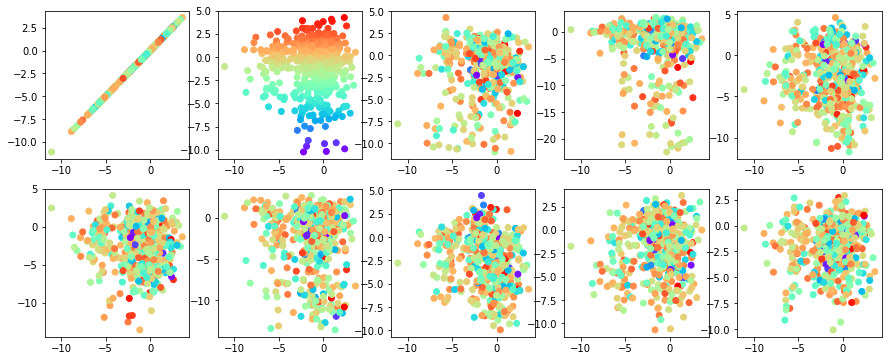

In [33]:
encoded_values = encoder_model.predict(np.array(frames[:1000]))
import matplotlib.cm as cm
%matplotlib inline
plt.figure(figsize=(15,6))
x_index = 0
color_index = 1
colors = cm.rainbow((encoded_values[:,color_index]-np.min(encoded_values[:,color_index]))/(np.max(encoded_values[:,color_index])-np.min(encoded_values[:,color_index])))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.scatter(encoded_values[:,x_index],encoded_values[:,i],color=colors)

In [34]:
len(frames)

461

In [8]:
result = frame
RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
cv2.imwrite('../../../../Mech Punk/Documents/sample_image.png',RGB_img)

True

In [35]:
# encoded_frames = encoder_model.predict(np.array(frames[0:1000]))
mean_encoded_frames = np.mean(encoded_values,axis=0)
min_encoded_frames = np.min(encoded_values,axis=0)
max_encoded_frames = np.max(encoded_values,axis=0)
std_encoded_frames = np.std(encoded_values,axis=0)

In [36]:
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 480, 640, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 240, 320, 8)  0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [37]:
mean_encoded_frames

array([-1.321657 , -1.1740986, -1.5826415, -2.4016259, -2.5184753,
       -2.5891674, -2.7469554, -2.4835758, -2.0767884, -2.0621917,
       -2.0107079, -3.2434058, -1.647589 , -2.971151 , -3.1127768,
       -0.9373879], dtype=float32)

In [38]:
std_encoded_frames

array([2.5078452, 2.6744854, 3.0325093, 4.936782 , 3.4849215, 3.1292157,
       3.886158 , 2.8920445, 2.8473325, 2.3034563, 4.0319495, 4.0018816,
       2.550542 , 3.2353005, 4.354897 , 2.1589234], dtype=float32)

KeyboardInterrupt: 

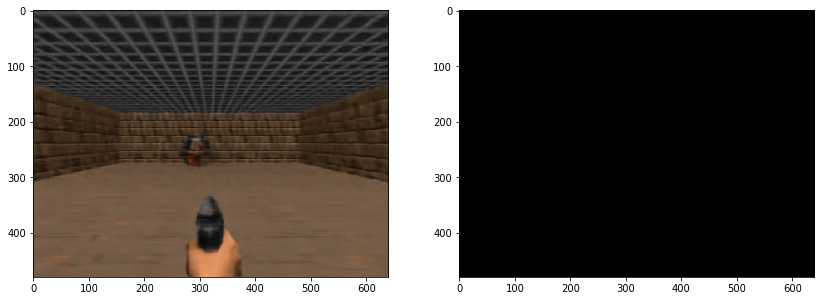

In [39]:
%matplotlib qt 
from tkinter import *
from IPython.display import clear_output
import time

master = Tk()

plt.figure(figsize=(14,5))
sp1 = plt.subplot(1,2,1)
sp2 = plt.subplot(1,2,2)

last_time_rendered=time.time()
initial_frame = 0
current_values = encoded_values[initial_frame].copy()
def change_values():
    global last_time_rendered
    current_time = time.time()
    if current_time - last_time_rendered < 0.25:
        return
    
    for slider_index, slider in enumerate(sliders):
        current_values[slider_index]=slider.get()
    clear_output()
    last_time_rendered = current_time
    prediction = decoder_model.predict(current_values.reshape(1,-1))[0]
    base_line = decoder_model.predict(encoded_values[initial_frame].reshape(1,-1))[0]
    
    sp1.clear()
    sp1.imshow(prediction)
    sp2.clear()
    sp2.imshow(np.abs(prediction-base_line))
    plt.draw()
    
def reset_values():
    global current_values
    current_values = encoded_values[initial_frame].copy()
    for slider_index, slider in enumerate(sliders):
        initial_value = current_values[slider_index]
        slider.set(initial_value)
    change_values()
        
    
sliders=[]
number_of_sliders = len(mean_encoded_frames)
labels = {
    0: "Dash",
    1: "Squeezing monster?",
    2: "Wall",
    
}
for slider_index in range(number_of_sliders):
    mean_value = mean_encoded_frames[slider_index]
    std_value = std_encoded_frames[slider_index]
    min_value = min_encoded_frames[slider_index]
    max_value = max_encoded_frames[slider_index]
    initial_value = current_values[slider_index]
    try:
        label_name = labels[slider_index]
    except:
        label_name = "{}".format(slider_index)
    row_index, column_index = divmod(slider_index,8)
    label = Label(master,text=label_name)
    label.grid(row = row_index, column = 2*column_index, pady=1, padx = 2)
    slider = Scale(master, 
                   from_=min_value, 
                   to=max_value, 
                   resolution=0.00001, 
                   orient=HORIZONTAL, 
                   command=lambda value: change_values())
    slider.set(initial_value)
#     slider.pack(side=BOTTOM)
    slider.grid(row = row_index, column = 2*column_index+1, pady=1, padx = 2)
    sliders.append(slider)
    
button = Button (master, text="   RESET   ", command=reset_values)
button.grid(row=row_index+1)

mainloop()

# 1700

## Checking the weights
### Check the encoder layers

In [51]:
for layer in encoder_model.layers:
    if type(layer) != Conv2D:
        continue
    max_weight = np.max(layer.get_weights()[0])
    min_weight = np.min(layer.get_weights()[0])
    max_bias = np.max(layer.get_weights()[1])
    min_bias = np.min(layer.get_weights()[1])
    print(max_weight, min_weight, max_bias, min_bias)

0.32738686 -0.59689164 0.25372517 -0.11600143
0.5884061 -0.8370553 0.18120003 -0.16824964
0.640431 -0.83539736 0.19068907 -0.14055252
0.68176734 -0.7906926 0.07550132 -0.17112063


In [53]:
for layer in decoder_model.layers:
    if type(layer) != Conv2D and type(layer) != Conv2DTranspose:
        continue
    max_weight = np.max(layer.get_weights()[0])
    min_weight = np.min(layer.get_weights()[0])
    max_bias = np.max(layer.get_weights()[1])
    min_bias = np.min(layer.get_weights()[1])
    print(max_weight, min_weight, max_bias, min_bias)

0.4957489 -0.47518277 0.9760397 -0.8470656
0.8852595 -1.9776806 1.4040573 -1.0986965
0.7390349 -1.6362115 1.1206012 -1.8941095
0.82805526 -1.2128031 0.6724748 -0.7938858
0.22984642 -1.0804832 -0.26763588 -0.70684636


0.32738686

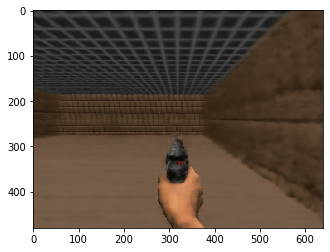

In [43]:
plt.imshow(focused_autoencoder_model.predict(np.array(frames[:1]))[0][0])

In [193]:
fourcc =  cv2.VideoWriter_fourcc(*'mp4v')
videowriter = cv2.VideoWriter(output_path,fourcc, fps, (640,480))
for result in results:
    RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
    videowriter.write(RGB_img)
videowriter.release()

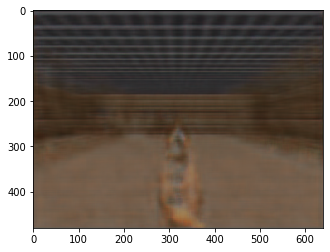

In [192]:
plt.imshow(np.uint8(255*result))

In [183]:

out = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), fps, (480,640))
for i in range(len(results)):
    # writing to a image array
    out.write(np.uint8(results[i]))
out.release()

In [70]:
game.close()

In [142]:
autoencoder_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 480, 640, 3)]     0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 480, 640, 8)       224       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 240, 320, 8)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 240, 320, 16)      1168      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 120, 160, 32)      4640      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 60, 80, 32)        0  

In [132]:
frame = (screen_buf/255)

In [144]:
encoded_frame = encoder_model.predict(np.expand_dims(frame, 0))
encoded_frame

array([[-0.0639854 , -0.12212464,  0.12227813, -0.1574321 ,  0.15349567,
        -0.08113714, -0.02606815,  0.15255773,  0.07415448, -0.09375374,
        -0.10602891,  0.05207051,  0.12839992, -0.14103197,  0.29119465,
        -0.10072614,  0.12248326,  0.06323166,  0.08846203, -0.04380043,
         0.06410899,  0.05987906,  0.0982798 , -0.09744385, -0.04132511,
        -0.09595089,  0.31295055, -0.02734107,  0.05040722,  0.01034025,
         0.03155817, -0.28869236]], dtype=float32)

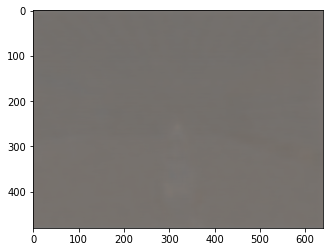

In [165]:
plt.imshow(decoder_model.predict(encoded_frame)[0])

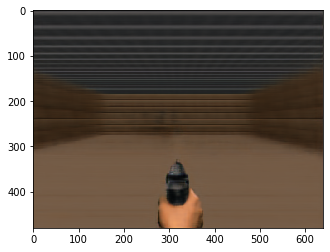

In [251]:
plt.imshow(autoencoder_model.predict(np.expand_dims(screen_buf/255, 0))[0])

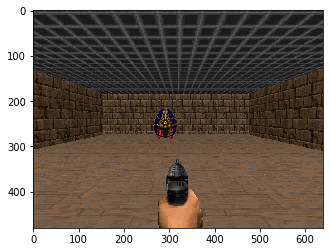

In [250]:
plt.imshow(screen_buf/255)

In [246]:
def get_game_state(state):
    game_object_state = []
    for game_object in state.objects:
        game_object_state = [
            game_object.angle,
    #         game_object.name,
            game_object.pitch,
            game_object.position_x,
            game_object.position_y,
            game_object.position_z,
            game_object.roll,
            game_object.velocity_x,
            game_object.velocity_y,
            game_object.velocity_z,]
        game_object_state+=game_object_state
    return game_object_state

In [247]:
get_game_state(state)

[180.00000004190952,
 0.0,
 0.0,
 60.504974365234375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.00000004190952,
 0.0,
 0.0,
 60.504974365234375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [236]:
state.objects[0].roll

0.0

In [237]:
game_object_states

[[0.0, 0.0, -384.0, 26.379196166992188, 0.0, 0.0, 0.0, -1.72308349609375, 0.0],
 [180.00000004190952, 0.0, 0.0, 60.504974365234375, 0.0, 0.0, 0.0, 0.0, 0.0]]

Episode #1


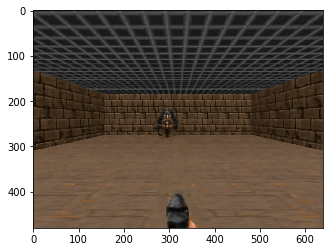

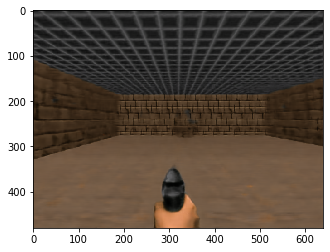

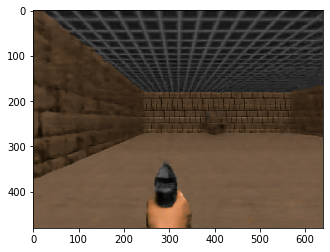

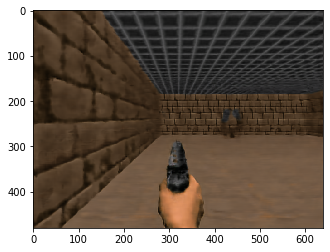

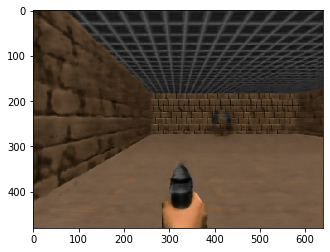

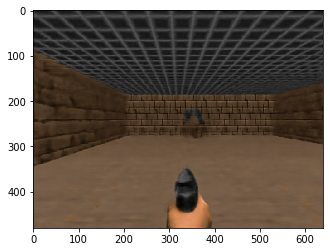

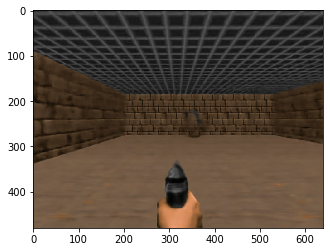

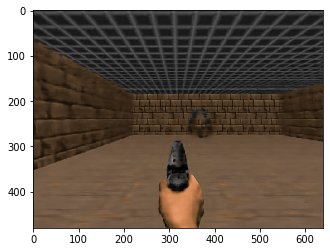

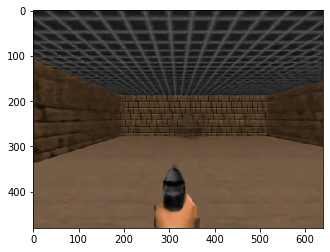

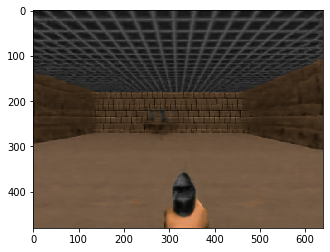

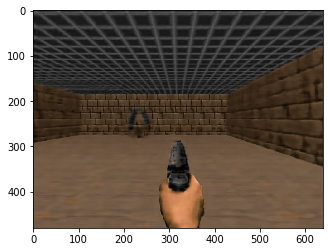

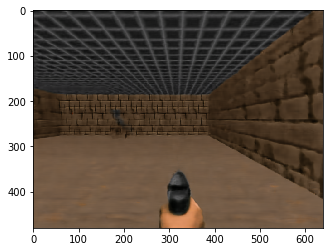

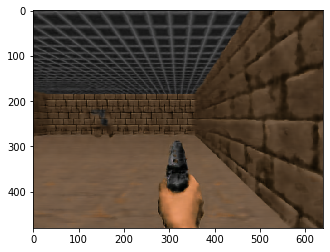

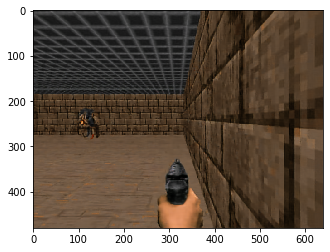

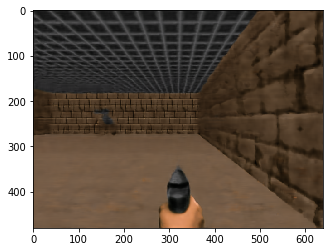

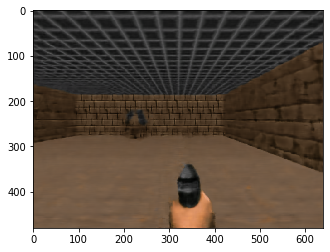

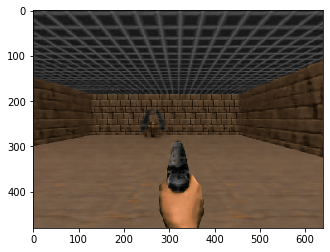

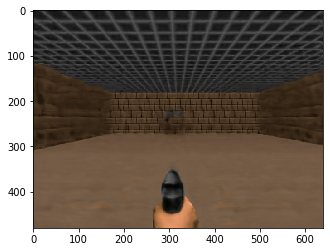

Episode #2


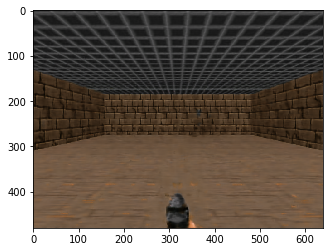

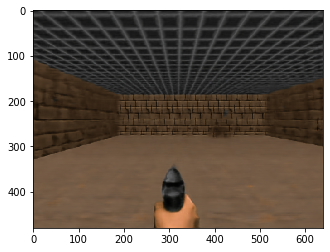

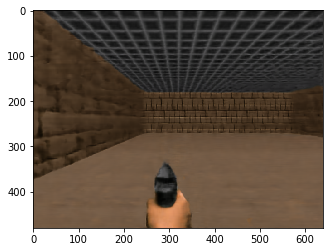

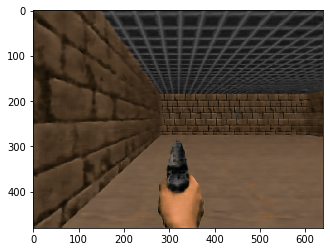

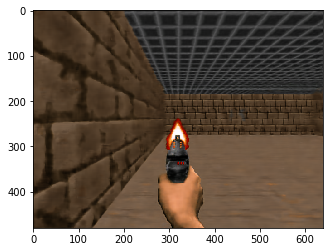

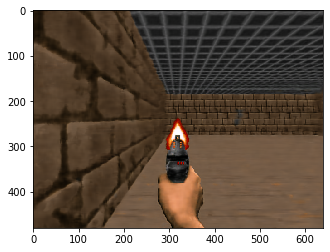

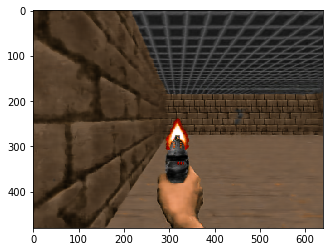

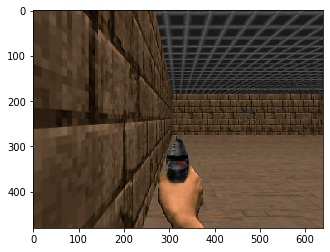

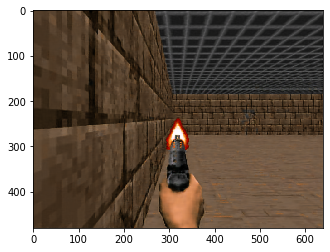

KeyboardInterrupt: 

In [35]:
# Play
vizdoom_path = "../../../../Mech Punk/Anaconda3/envs/vizdoom/lib/vizdoom/scenarios/"

if __name__ == "__main__":
    # Create DoomGame instance. It will run the game and communicate with you.
    game = vzd.DoomGame()

    # Now it's time for configuration!
    # load_config could be used to load configuration instead of doing it here with code.
    # If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
    # game.load_config("../../scenarios/basic.cfg")

    # Sets path to additional resources wad file which is basically your scenario wad.
    # If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
    game.set_doom_scenario_path(vizdoom_path + "basic.wad")
    # Sets map to start (scenario .wad files can contain many maps).
    game.set_doom_map("map01")

    # Sets resolution. Default is 320X240
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

    # Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
    game.set_screen_format(vzd.ScreenFormat.RGB24)

    # Enables depth buffer.
    game.set_depth_buffer_enabled(True)

    # Enables labeling of in game objects labeling.
    game.set_labels_buffer_enabled(True)

    # Enables buffer with top down map of the current episode/level.
    game.set_automap_buffer_enabled(True)

    # Enables information about all objects present in the current episode/level.
    game.set_objects_info_enabled(True)

    # Enables information about all sectors (map layout).
    game.set_sectors_info_enabled(True)

    # Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)  # If hud is enabled
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)  # Bullet holes and blood on the walls
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)  # Smoke and blood
    game.set_render_messages(False)  # In-game messages
    game.set_render_corpses(False)
    game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

    # Adds buttons that will be allowed.
    game.add_available_button(vzd.Button.MOVE_LEFT)
    game.add_available_button(vzd.Button.MOVE_RIGHT)
    game.add_available_button(vzd.Button.ATTACK)

    # Adds game variables that will be included in state.
    game.add_available_game_variable(vzd.GameVariable.AMMO2)

    # Causes episodes to finish after 200 tics (actions)
    game.set_episode_timeout(300)

    # Makes episodes start after 10 tics (~after raising the weapon)
    game.set_episode_start_time(10)

    # Makes the window appear (turned on by default)
    game.set_window_visible(False)

    # Turns on the sound. (turned off by default)
    game.set_sound_enabled(False)

    # Sets the livin reward (for each move) to -1
    game.set_living_reward(-1)

    # Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
    game.set_mode(vzd.Mode.PLAYER)

    # Enables engine output to console.
    #game.set_console_enabled(True)

    # Initialize the game. Further configuration won't take any effect from now on.
    game.init()

    # Define some actions. Each list entry corresponds to declared buttons:
    # MOVE_LEFT, MOVE_RIGHT, ATTACK
    # game.get_available_buttons_size() can be used to check the number of available buttons.
    # 5 more combinations are naturally possible but only 3 are included for transparency when watching.
    actions = [[True, False, False], [False, True, False], [False, False, True]]

    # Run this many episodes
    episodes = 100000000

    # Sets time that will pause the engine after each action (in seconds)
    # Without this everything would go too fast for you to keep track of what's happening.
    sleep_time = 1.0 / vzd.DEFAULT_TICRATE  # = 0.028
    

    for i in range(episodes):
        print("Episode #" + str(i + 1))

        # Starts a new episode. It is not needed right after init() but it doesn't cost much. At least the loop is nicer.
        game.new_episode()

        action_counter = 0
        counter = 0
        
        
        while not game.is_episode_finished():
            
            action_counter-=1

            # Gets the state
            state = game.get_state()

            # Which consists of:
            n = state.number
            vars = state.game_variables
            screen_buf = state.screen_buffer
            depth_buf = state.depth_buffer
            labels_buf = state.labels_buffer
            automap_buf = state.automap_buffer
            labels = state.labels
            objects = state.objects
            sectors = state.sectors
            
            time.sleep(0.1)
            
            frame = screen_buf/255
            plt.imshow(autoencoder_model.predict(np.expand_dims(frame,0))[0])
            plt.show()
#             if action_counter < 0:
#                 action = choice(actions)
#                 action_counter = np.random.randint(0,20)
            action = choice(actions)
            r = game.make_action(action,12)

In [ ]:
game.make_action(action)

In [14]:
encodings = encoder_model.predict(np.array(frames[0:100]))

In [22]:
encoding_drawing = encodings.mean(axis=0) + encodings.std(axis=0) * np.random.randn(32)

In [25]:
frame_drawing = decoder_model.predict(encoding_drawing.reshape(1,-1))[0]

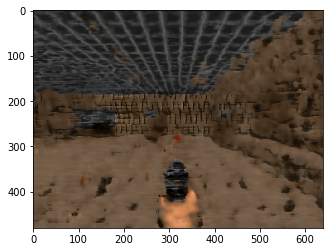

In [27]:
plt.imshow(frame_drawing)